<a href="https://colab.research.google.com/github/ivanpalenciab/prediccion-precio-maiz/blob/Modelo_SSA/Red_recurrente_SSA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [20]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [21]:
!pip install optuna

In [22]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt

import tensorflow as tf

#modulos sklearn
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error
from sklearn.preprocessing import MinMaxScaler

#modulos keras
from keras.models import Sequential
from keras.layers import LSTM, Dense
from tensorflow.keras.utils import plot_model
from keras.callbacks import EarlyStopping

In [23]:
#Importamos las componentes
componente_1 = pd.read_csv('/content/drive/MyDrive/prediccion_productos_agro/descompocion-ensamble/modes/ssa_componentes/componente_1.csv')
componente_2 = pd.read_csv('/content/drive/MyDrive/prediccion_productos_agro/descompocion-ensamble/modes/ssa_componentes/componente_2.csv')
componente_3 = pd.read_csv('/content/drive/MyDrive/prediccion_productos_agro/descompocion-ensamble/modes/ssa_componentes/componente_3.csv')
componente_4 = pd.read_csv('/content/drive/MyDrive/prediccion_productos_agro/descompocion-ensamble/modes/ssa_componentes/componente_4.csv')
componentes = [componente_1,componente_2,componente_3,componente_4]
for componente in componentes:
  componente["Fecha"] = pd.to_datetime(componente["Fecha"],format='%Y-%m-%d')
  componente.set_index("Fecha", inplace=True)

<Axes: xlabel='Fecha'>

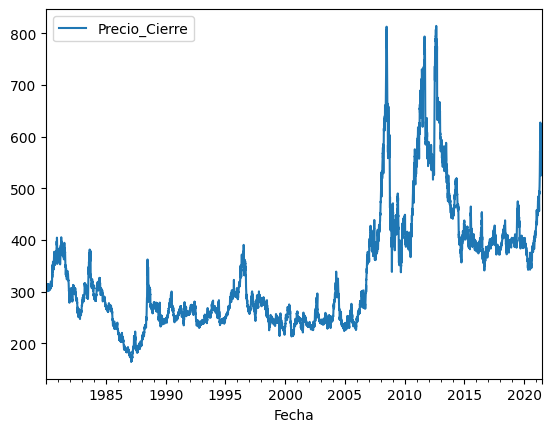

In [24]:
datos_originales = pd.read_csv('/content/drive/MyDrive/prediccion_productos_agro/datos_maiz.csv')
datos_originales = datos_originales.rename(columns={'Date': 'Fecha', 'Last': 'Precio_Cierre'})
datos_originales["Fecha"] =  pd.to_datetime(datos_originales["Fecha"],format='%Y-%m-%d')
datos_originales.set_index("Fecha", inplace=True)
datos_originales = datos_originales.asfreq('D')
datos_originales.interpolate(inplace=True)
datos_originales.plot()

In [25]:
def add_lags(df,pasos):
    target_map = df['Precio_Cierre'].to_dict()
    for i in range(pasos+1):
      df[f'retraso-{i}'] = (df.index - pd.Timedelta(f'{i} days')).map(target_map)
    df = df.drop(columns=["retraso-0"])
    df.dropna(inplace=True)
    return df

In [26]:
def a_supervisado(df):
  df = df.asfreq('D')
  df.interpolate(inplace=True)
  df_values = df.values
  df_values = df_values.astype('float32')
  df_scaler = MinMaxScaler(feature_range=(-1, 1))
  df_values = df_values.reshape(-1, 1)
  df_escalado =  pd.DataFrame(df_scaler.fit_transform(df_values), columns=df.columns,index=df.index)
  df_sup = add_lags(df_escalado, 7)
  df_sup.head(5)

  return df_sup, df_scaler

In [27]:
def division_datos(df):
  total_datos=len(df)
  porcentaje_entrenamiento, porcentaje_validacion = 0.8,0.1
  division_entrenamiento = int(total_datos*porcentaje_entrenamiento)
  division_validacion = division_entrenamiento + int(porcentaje_validacion*total_datos)


  datos_entrenamiento = df[:division_entrenamiento]
  datos_validacion = df[division_entrenamiento:division_validacion]
  datos_testeo = df[division_validacion:total_datos]

  datos_entrenamiento_values= datos_entrenamiento.values.astype('float32')
  datos_validacion_values = datos_validacion.values.astype('float32')
  datos_testeo_values = datos_testeo.values.astype('float32')

  X_train, y_train = datos_entrenamiento_values[:, :-1], datos_entrenamiento_values[:, -1]
  X_val, y_val = datos_validacion_values[:, :-1], datos_validacion_values[:, -1]
  X_test, y_test = datos_testeo_values[:, :-1], datos_testeo_values[:, -1]

  X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
  X_val = X_val.reshape((X_val.shape[0], 1, X_val.shape[1]))
  X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

  print(X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape , y_test.shape)

  return datos_entrenamiento, datos_validacion, datos_testeo, X_train, y_train, X_val, y_val, X_test, y_test

In [28]:
import optuna
from keras.optimizers import Adam

# Función de objetivo para Optuna
def objective(trial):
    # Definir el modelo Keras
    model = Sequential()
    model.add(LSTM(trial.suggest_int('units', 10, 70), input_shape=(1,7),return_sequences=True)) # Capa de entrada con unidades variables
    for i in range(trial.suggest_int('n_layers',1,2)): # Número de capas ocultas
        model.add(LSTM(trial.suggest_int(f'units_{i}', 7, 70), activation='tanh',return_sequences=True)) # Capas ocultas con unidades variables
    model.add(Dense(1)) # Capa de salida

    # Compilar el modelo
    model.compile(optimizer=tf.keras.optimizers.RMSprop(trial.suggest_float('learning_rate', 0.0001, 0.1)),
                  loss='mean_squared_error')

    # Entrenar el modelo
    model.fit(X_train, y_train, epochs=3, batch_size=7, verbose=0)

    # Evaluar el modelo
    predictions = model.predict(X_val)
    mse = mean_squared_error(predictions.reshape(-1), y_val)

    return mse

# vamos a modelar el primer modelo

In [37]:
componente_1_sup , componente_1_scaler = a_supervisado(componente_1)

In [38]:
componente_1_sup.head(5)

,Precio_Cierre,retraso-1,retraso-2,retraso-3,retraso-4,retraso-5,retraso-6,retraso-7
Fecha,,,,,,,,
1980-01-09,-0.545235,-0.545220,-0.545205,-0.545190,-0.545175,-0.545160,-0.545094,-0.545102
1980-01-10,-0.545073,-0.545235,-0.545220,-0.545205,-0.545190,-0.545175,-0.545160,-0.545094
1980-01-11,-0.544715,-0.545073,-0.545235,-0.545220,-0.545205,-0.545190,-0.545175,-0.545160
1980-01-12,-0.544569,-0.544715,-0.545073,-0.545235,-0.545220,-0.545205,-0.545190,-0.545175
1980-01-13,-0.544423,-0.544569,-0.544715,-0.545073,-0.545235,-0.545220,-0.545205,-0.545190


In [39]:
datos_entrenamiento_c1, datos_validacion_c1, datos_testeo_c1, X_train, y_train, X_val, y_val, X_test, y_test = division_datos(componente_1_sup)

(12118, 1, 7) (12118,) (1514, 1, 7) (1514,) (1516, 1, 7) (1516,)


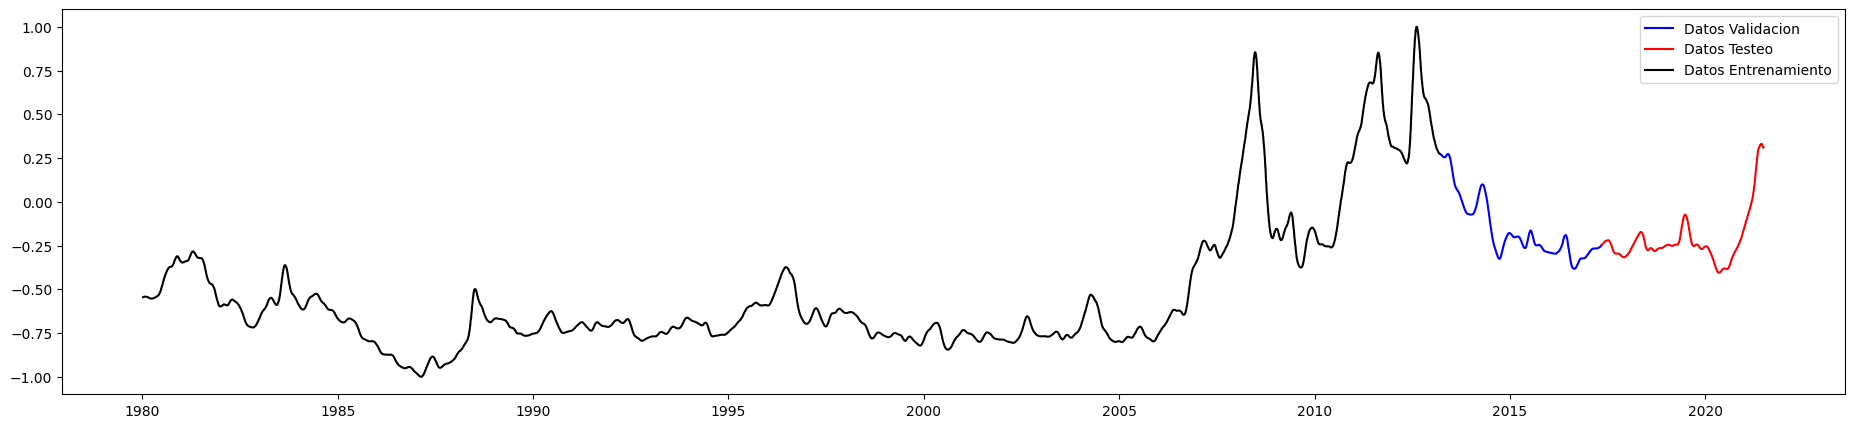

In [40]:
fig, ax = plt.subplots(figsize=(23, 5))
ax.plot(datos_validacion_c1.index,datos_validacion_c1.Precio_Cierre,color='blue',label = 'Datos Validacion')
ax.plot(datos_testeo_c1.index,datos_testeo_c1.Precio_Cierre,color='red',label = 'Datos Testeo')
ax.plot(datos_entrenamiento_c1.index,datos_entrenamiento_c1.Precio_Cierre,color='black',label = 'Datos Entrenamiento')
ax.legend(loc = 'upper right')
plt.show()

In [ ]:
# Crear un estudio Optuna
study = optuna.create_study(direction='minimize')

# Ejecutar la optimización de hiperparámetros
study.optimize(objective, n_trials=100)

# Obtener los mejores hiperparámetros
best_params = study.best_params
print("Mejores hiperparámetros:", best_params)

[I 2024-06-20 16:12:32,246] A new study created in memory with name: no-name-79b8576d-eab2-4357-aa1b-ad993492ba6c


48/48 [==============================] - 1s 3ms/step


[I 2024-06-20 16:13:02,079] Trial 0 finished with value: 0.1039694994688034 and parameters: {'units': 17, 'n_layers': 1, 'units_0': 35, 'learning_rate': 0.018689005762853407}. Best is trial 0 with value: 0.1039694994688034.


48/48 [==============================] - 1s 3ms/step


[I 2024-06-20 16:13:43,533] Trial 1 finished with value: 0.26719188690185547 and parameters: {'units': 57, 'n_layers': 2, 'units_0': 58, 'units_1': 53, 'learning_rate': 0.07879762516107736}. Best is trial 0 with value: 0.1039694994688034.


48/48 [==============================] - 1s 3ms/step


[I 2024-06-20 16:14:12,285] Trial 2 finished with value: 0.13233675062656403 and parameters: {'units': 35, 'n_layers': 1, 'units_0': 43, 'learning_rate': 0.0079333183539098}. Best is trial 0 with value: 0.1039694994688034.


48/48 [==============================] - 1s 3ms/step


[I 2024-06-20 16:14:58,593] Trial 3 finished with value: 0.09774472564458847 and parameters: {'units': 23, 'n_layers': 1, 'units_0': 57, 'learning_rate': 0.09250333564297006}. Best is trial 3 with value: 0.09774472564458847.


48/48 [==============================] - 1s 3ms/step


[I 2024-06-20 16:15:29,187] Trial 4 finished with value: 0.08035989850759506 and parameters: {'units': 59, 'n_layers': 1, 'units_0': 11, 'learning_rate': 0.046077121992756605}. Best is trial 4 with value: 0.08035989850759506.


48/48 [==============================] - 2s 4ms/step


[I 2024-06-20 16:16:18,909] Trial 5 finished with value: 0.11829416453838348 and parameters: {'units': 40, 'n_layers': 2, 'units_0': 7, 'units_1': 44, 'learning_rate': 0.0525065754992177}. Best is trial 4 with value: 0.08035989850759506.


48/48 [==============================] - 1s 3ms/step


[I 2024-06-20 16:17:06,185] Trial 6 finished with value: 0.15362419188022614 and parameters: {'units': 29, 'n_layers': 1, 'units_0': 69, 'learning_rate': 0.06345733168285304}. Best is trial 4 with value: 0.08035989850759506.


48/48 [==============================] - 2s 4ms/step


[I 2024-06-20 16:17:46,259] Trial 7 finished with value: 0.2564641535282135 and parameters: {'units': 41, 'n_layers': 2, 'units_0': 39, 'units_1': 63, 'learning_rate': 0.049449339467053974}. Best is trial 4 with value: 0.08035989850759506.


48/48 [==============================] - 1s 3ms/step


[I 2024-06-20 16:18:16,317] Trial 8 finished with value: 0.15927667915821075 and parameters: {'units': 50, 'n_layers': 1, 'units_0': 46, 'learning_rate': 0.07102121288020709}. Best is trial 4 with value: 0.08035989850759506.


48/48 [==============================] - 1s 3ms/step


[I 2024-06-20 16:19:02,484] Trial 9 finished with value: 0.13299782574176788 and parameters: {'units': 69, 'n_layers': 1, 'units_0': 41, 'learning_rate': 0.023539355716266766}. Best is trial 4 with value: 0.08035989850759506.


48/48 [==============================] - 2s 5ms/step


[I 2024-06-20 16:19:53,581] Trial 10 finished with value: 0.04960935562849045 and parameters: {'units': 69, 'n_layers': 2, 'units_0': 7, 'units_1': 9, 'learning_rate': 0.03419639602389633}. Best is trial 10 with value: 0.04960935562849045.


48/48 [==============================] - 1s 3ms/step


[I 2024-06-20 16:20:42,776] Trial 11 finished with value: 0.06702271103858948 and parameters: {'units': 70, 'n_layers': 2, 'units_0': 8, 'units_1': 9, 'learning_rate': 0.03613134297870689}. Best is trial 10 with value: 0.04960935562849045.


48/48 [==============================] - 2s 3ms/step


[I 2024-06-20 16:21:23,715] Trial 12 finished with value: 0.2194269895553589 and parameters: {'units': 70, 'n_layers': 2, 'units_0': 20, 'units_1': 8, 'learning_rate': 0.034508418821344436}. Best is trial 10 with value: 0.04960935562849045.


48/48 [==============================] - 2s 5ms/step


[I 2024-06-20 16:22:04,496] Trial 13 finished with value: 0.1466296911239624 and parameters: {'units': 61, 'n_layers': 2, 'units_0': 22, 'units_1': 8, 'learning_rate': 0.0005428089348298512}. Best is trial 10 with value: 0.04960935562849045.


48/48 [==============================] - 2s 3ms/step


[I 2024-06-20 16:22:44,460] Trial 14 finished with value: 0.14299681782722473 and parameters: {'units': 50, 'n_layers': 2, 'units_0': 19, 'units_1': 23, 'learning_rate': 0.03328798412383139}. Best is trial 10 with value: 0.04960935562849045.


48/48 [==============================] - 2s 4ms/step


[I 2024-06-20 16:23:25,513] Trial 15 finished with value: 0.13536687195301056 and parameters: {'units': 65, 'n_layers': 2, 'units_0': 28, 'units_1': 25, 'learning_rate': 0.03573382263658922}. Best is trial 10 with value: 0.04960935562849045.


48/48 [==============================] - 2s 3ms/step


[I 2024-06-20 16:24:14,546] Trial 16 finished with value: 0.12705418467521667 and parameters: {'units': 55, 'n_layers': 2, 'units_0': 16, 'units_1': 22, 'learning_rate': 0.018768081444145268}. Best is trial 10 with value: 0.04960935562849045.


48/48 [==============================] - 2s 3ms/step


[I 2024-06-20 16:24:56,529] Trial 17 finished with value: 0.15586309134960175 and parameters: {'units': 50, 'n_layers': 2, 'units_0': 28, 'units_1': 16, 'learning_rate': 0.05757181423908528}. Best is trial 10 with value: 0.04960935562849045.


48/48 [==============================] - 2s 5ms/step


[I 2024-06-20 16:25:47,255] Trial 18 finished with value: 0.14220114052295685 and parameters: {'units': 64, 'n_layers': 2, 'units_0': 7, 'units_1': 35, 'learning_rate': 0.04312432558487577}. Best is trial 10 with value: 0.04960935562849045.


48/48 [==============================] - 2s 4ms/step


[I 2024-06-20 16:26:37,656] Trial 19 finished with value: 0.15114657580852509 and parameters: {'units': 11, 'n_layers': 2, 'units_0': 13, 'units_1': 36, 'learning_rate': 0.027115524355540613}. Best is trial 10 with value: 0.04960935562849045.


48/48 [==============================] - 2s 4ms/step


[I 2024-06-20 16:27:20,066] Trial 20 finished with value: 0.07701944559812546 and parameters: {'units': 44, 'n_layers': 2, 'units_0': 28, 'units_1': 15, 'learning_rate': 0.012106913269015786}. Best is trial 10 with value: 0.04960935562849045.


48/48 [==============================] - 2s 4ms/step


[I 2024-06-20 16:28:02,003] Trial 21 finished with value: 0.11457778513431549 and parameters: {'units': 46, 'n_layers': 2, 'units_0': 27, 'units_1': 7, 'learning_rate': 0.009732274404415382}. Best is trial 10 with value: 0.04960935562849045.


48/48 [==============================] - 2s 3ms/step


[I 2024-06-20 16:28:50,860] Trial 22 finished with value: 0.1481645405292511 and parameters: {'units': 34, 'n_layers': 2, 'units_0': 33, 'units_1': 16, 'learning_rate': 0.011234767239257473}. Best is trial 10 with value: 0.04960935562849045.


48/48 [==============================] - 2s 4ms/step


[I 2024-06-20 16:29:41,283] Trial 23 finished with value: 0.16209158301353455 and parameters: {'units': 70, 'n_layers': 2, 'units_0': 12, 'units_1': 16, 'learning_rate': 0.03806948691338363}. Best is trial 10 with value: 0.04960935562849045.


48/48 [==============================] - 2s 4ms/step


[I 2024-06-20 16:30:30,272] Trial 24 finished with value: 0.2071715146303177 and parameters: {'units': 64, 'n_layers': 2, 'units_0': 24, 'units_1': 29, 'learning_rate': 0.02746046921658641}. Best is trial 10 with value: 0.04960935562849045.


48/48 [==============================] - 1s 3ms/step


[I 2024-06-20 16:31:11,277] Trial 25 finished with value: 0.1205286830663681 and parameters: {'units': 53, 'n_layers': 2, 'units_0': 15, 'units_1': 14, 'learning_rate': 0.01470366849563626}. Best is trial 10 with value: 0.04960935562849045.


48/48 [==============================] - 2s 4ms/step


[I 2024-06-20 16:31:54,262] Trial 26 finished with value: 0.12305284291505814 and parameters: {'units': 45, 'n_layers': 2, 'units_0': 7, 'units_1': 13, 'learning_rate': 0.0001306143046113182}. Best is trial 10 with value: 0.04960935562849045.


48/48 [==============================] - 1s 4ms/step


[I 2024-06-20 16:32:37,449] Trial 27 finished with value: 0.1812174767255783 and parameters: {'units': 62, 'n_layers': 2, 'units_0': 47, 'units_1': 29, 'learning_rate': 0.02754621422169842}. Best is trial 10 with value: 0.04960935562849045.


48/48 [==============================] - 1s 3ms/step


[I 2024-06-20 16:33:26,609] Trial 28 finished with value: 0.030588654801249504 and parameters: {'units': 24, 'n_layers': 2, 'units_0': 34, 'units_1': 45, 'learning_rate': 0.04349768144556886}. Best is trial 28 with value: 0.030588654801249504.


48/48 [==============================] - 2s 4ms/step


[I 2024-06-20 16:34:06,960] Trial 29 finished with value: 0.03485998883843422 and parameters: {'units': 24, 'n_layers': 2, 'units_0': 32, 'units_1': 48, 'learning_rate': 0.0563753452671543}. Best is trial 28 with value: 0.030588654801249504.


48/48 [==============================] - 2s 4ms/step


[I 2024-06-20 16:34:46,472] Trial 30 finished with value: 0.2190542221069336 and parameters: {'units': 19, 'n_layers': 2, 'units_0': 34, 'units_1': 47, 'learning_rate': 0.06111656349572036}. Best is trial 28 with value: 0.030588654801249504.


48/48 [==============================] - 2s 5ms/step


[I 2024-06-20 16:35:26,463] Trial 31 finished with value: 0.06402810662984848 and parameters: {'units': 25, 'n_layers': 2, 'units_0': 34, 'units_1': 58, 'learning_rate': 0.04186976224013149}. Best is trial 28 with value: 0.030588654801249504.


48/48 [==============================] - 2s 4ms/step


[I 2024-06-20 16:36:18,103] Trial 32 finished with value: 0.22399237751960754 and parameters: {'units': 26, 'n_layers': 2, 'units_0': 52, 'units_1': 57, 'learning_rate': 0.05407534958726269}. Best is trial 28 with value: 0.030588654801249504.


48/48 [==============================] - 2s 4ms/step


[I 2024-06-20 16:37:01,247] Trial 33 finished with value: 0.20011448860168457 and parameters: {'units': 14, 'n_layers': 2, 'units_0': 34, 'units_1': 66, 'learning_rate': 0.043518810735845535}. Best is trial 28 with value: 0.030588654801249504.


48/48 [==============================] - 1s 3ms/step


[I 2024-06-20 16:37:43,571] Trial 34 finished with value: 0.05249156802892685 and parameters: {'units': 20, 'n_layers': 2, 'units_0': 37, 'units_1': 46, 'learning_rate': 0.0831678633341926}. Best is trial 28 with value: 0.030588654801249504.


48/48 [==============================] - 2s 5ms/step


[I 2024-06-20 16:38:34,405] Trial 35 finished with value: 0.008175940252840519 and parameters: {'units': 18, 'n_layers': 2, 'units_0': 38, 'units_1': 43, 'learning_rate': 0.09061498621256915}. Best is trial 35 with value: 0.008175940252840519.


48/48 [==============================] - 1s 3ms/step


[I 2024-06-20 16:39:05,393] Trial 36 finished with value: 0.18170058727264404 and parameters: {'units': 32, 'n_layers': 1, 'units_0': 45, 'learning_rate': 0.090878166191935}. Best is trial 35 with value: 0.008175940252840519.


48/48 [==============================] - 2s 5ms/step


[I 2024-06-20 16:39:44,487] Trial 37 finished with value: 0.303240567445755 and parameters: {'units': 15, 'n_layers': 2, 'units_0': 51, 'units_1': 40, 'learning_rate': 0.09889272332851712}. Best is trial 35 with value: 0.008175940252840519.


48/48 [==============================] - 2s 5ms/step


[I 2024-06-20 16:40:17,329] Trial 38 finished with value: 0.2100808471441269 and parameters: {'units': 21, 'n_layers': 1, 'units_0': 64, 'learning_rate': 0.07241607412219299}. Best is trial 35 with value: 0.008175940252840519.


48/48 [==============================] - 2s 4ms/step


[I 2024-06-20 16:41:08,870] Trial 39 finished with value: 0.13927501440048218 and parameters: {'units': 29, 'n_layers': 2, 'units_0': 31, 'units_1': 49, 'learning_rate': 0.06985252664163241}. Best is trial 35 with value: 0.008175940252840519.


48/48 [==============================] - 1s 4ms/step


[I 2024-06-20 16:41:50,469] Trial 40 finished with value: 0.15130941569805145 and parameters: {'units': 37, 'n_layers': 2, 'units_0': 42, 'units_1': 54, 'learning_rate': 0.04973889575715931}. Best is trial 35 with value: 0.008175940252840519.


48/48 [==============================] - 2s 4ms/step


[I 2024-06-20 16:42:32,505] Trial 41 finished with value: 0.2435489147901535 and parameters: {'units': 18, 'n_layers': 2, 'units_0': 39, 'units_1': 41, 'learning_rate': 0.0812488934214846}. Best is trial 35 with value: 0.008175940252840519.


48/48 [==============================] - 1s 3ms/step


[I 2024-06-20 16:43:14,693] Trial 42 finished with value: 0.2149147242307663 and parameters: {'units': 22, 'n_layers': 2, 'units_0': 51, 'units_1': 49, 'learning_rate': 0.0844079629650878}. Best is trial 35 with value: 0.008175940252840519.


48/48 [==============================] - 2s 4ms/step


[I 2024-06-20 16:43:53,655] Trial 43 finished with value: 0.01622777432203293 and parameters: {'units': 11, 'n_layers': 2, 'units_0': 38, 'units_1': 43, 'learning_rate': 0.09074094888079438}. Best is trial 35 with value: 0.008175940252840519.


48/48 [==============================] - 1s 3ms/step


[I 2024-06-20 16:44:33,490] Trial 44 finished with value: 0.014823767356574535 and parameters: {'units': 10, 'n_layers': 2, 'units_0': 38, 'units_1': 43, 'learning_rate': 0.08947850891371618}. Best is trial 35 with value: 0.008175940252840519.


48/48 [==============================] - 1s 3ms/step


[I 2024-06-20 16:45:23,695] Trial 45 finished with value: 0.031726643443107605 and parameters: {'units': 10, 'n_layers': 2, 'units_0': 39, 'units_1': 43, 'learning_rate': 0.09056794333760798}. Best is trial 35 with value: 0.008175940252840519.


48/48 [==============================] - 1s 3ms/step


[I 2024-06-20 16:45:53,105] Trial 46 finished with value: 0.26405107975006104 and parameters: {'units': 12, 'n_layers': 1, 'units_0': 37, 'learning_rate': 0.08999583003448806}. Best is trial 35 with value: 0.008175940252840519.


48/48 [==============================] - 2s 4ms/step


[I 2024-06-20 16:46:39,413] Trial 47 finished with value: 0.2210879623889923 and parameters: {'units': 10, 'n_layers': 2, 'units_0': 40, 'units_1': 43, 'learning_rate': 0.09777697559067308}. Best is trial 35 with value: 0.008175940252840519.


48/48 [==============================] - 1s 4ms/step


[I 2024-06-20 16:47:22,232] Trial 48 finished with value: 0.1804501712322235 and parameters: {'units': 16, 'n_layers': 2, 'units_0': 37, 'units_1': 36, 'learning_rate': 0.07638971588351845}. Best is trial 35 with value: 0.008175940252840519.


48/48 [==============================] - 2s 4ms/step


[I 2024-06-20 16:48:04,211] Trial 49 finished with value: 0.1877686083316803 and parameters: {'units': 14, 'n_layers': 2, 'units_0': 43, 'units_1': 44, 'learning_rate': 0.08812808616499203}. Best is trial 35 with value: 0.008175940252840519.


48/48 [==============================] - 2s 4ms/step


[I 2024-06-20 16:48:53,121] Trial 50 finished with value: 0.350953608751297 and parameters: {'units': 13, 'n_layers': 2, 'units_0': 47, 'units_1': 52, 'learning_rate': 0.09649700747786387}. Best is trial 35 with value: 0.008175940252840519.


48/48 [==============================] - 1s 3ms/step


[I 2024-06-20 16:49:43,520] Trial 51 finished with value: 0.013765331357717514 and parameters: {'units': 17, 'n_layers': 2, 'units_0': 31, 'units_1': 38, 'learning_rate': 0.09469739226040894}. Best is trial 35 with value: 0.008175940252840519.


48/48 [==============================] - 2s 5ms/step


[I 2024-06-20 16:50:23,342] Trial 52 finished with value: 0.2985438108444214 and parameters: {'units': 17, 'n_layers': 2, 'units_0': 30, 'units_1': 39, 'learning_rate': 0.09411751454852169}. Best is trial 35 with value: 0.008175940252840519.


48/48 [==============================] - 2s 4ms/step


[I 2024-06-20 16:51:02,596] Trial 53 finished with value: 0.24095433950424194 and parameters: {'units': 10, 'n_layers': 2, 'units_0': 36, 'units_1': 33, 'learning_rate': 0.08459329073358095}. Best is trial 35 with value: 0.008175940252840519.


48/48 [==============================] - 2s 3ms/step


[I 2024-06-20 16:51:42,368] Trial 54 finished with value: 0.202041894197464 and parameters: {'units': 17, 'n_layers': 2, 'units_0': 25, 'units_1': 43, 'learning_rate': 0.08756035544390173}. Best is trial 35 with value: 0.008175940252840519.


48/48 [==============================] - 2s 5ms/step


[I 2024-06-20 16:52:32,801] Trial 55 finished with value: 0.04649326205253601 and parameters: {'units': 12, 'n_layers': 2, 'units_0': 41, 'units_1': 32, 'learning_rate': 0.07721872895409554}. Best is trial 35 with value: 0.008175940252840519.


48/48 [==============================] - 2s 4ms/step


[I 2024-06-20 16:53:26,275] Trial 56 finished with value: 0.21457920968532562 and parameters: {'units': 28, 'n_layers': 2, 'units_0': 45, 'units_1': 52, 'learning_rate': 0.09370513399074858}. Best is trial 35 with value: 0.008175940252840519.


48/48 [==============================] - 2s 3ms/step


[I 2024-06-20 16:54:17,034] Trial 57 finished with value: 0.29897430539131165 and parameters: {'units': 15, 'n_layers': 2, 'units_0': 30, 'units_1': 38, 'learning_rate': 0.08026630905367146}. Best is trial 35 with value: 0.008175940252840519.


48/48 [==============================] - 1s 4ms/step


[I 2024-06-20 16:54:55,016] Trial 58 finished with value: 0.2383962869644165 and parameters: {'units': 19, 'n_layers': 2, 'units_0': 40, 'units_1': 45, 'learning_rate': 0.09429020266767633}. Best is trial 35 with value: 0.008175940252840519.


48/48 [==============================] - 1s 3ms/step


[I 2024-06-20 16:55:45,282] Trial 59 finished with value: 0.02157270722091198 and parameters: {'units': 22, 'n_layers': 2, 'units_0': 38, 'units_1': 42, 'learning_rate': 0.06656262509692562}. Best is trial 35 with value: 0.008175940252840519.


48/48 [==============================] - 2s 4ms/step


[I 2024-06-20 16:56:34,145] Trial 60 finished with value: 0.22346986830234528 and parameters: {'units': 23, 'n_layers': 2, 'units_0': 26, 'units_1': 40, 'learning_rate': 0.06676013900788809}. Best is trial 35 with value: 0.008175940252840519.


48/48 [==============================] - 1s 3ms/step


[I 2024-06-20 16:57:23,552] Trial 61 finished with value: 0.2583516836166382 and parameters: {'units': 12, 'n_layers': 2, 'units_0': 38, 'units_1': 42, 'learning_rate': 0.0866558186032325}. Best is trial 35 with value: 0.008175940252840519.


48/48 [==============================] - 2s 5ms/step


[I 2024-06-20 16:58:12,862] Trial 62 finished with value: 0.15386736392974854 and parameters: {'units': 16, 'n_layers': 2, 'units_0': 43, 'units_1': 37, 'learning_rate': 0.0909262687689954}. Best is trial 35 with value: 0.008175940252840519.


48/48 [==============================] - 1s 3ms/step


[I 2024-06-20 16:59:01,786] Trial 63 finished with value: 0.014091516844928265 and parameters: {'units': 21, 'n_layers': 2, 'units_0': 35, 'units_1': 33, 'learning_rate': 0.07422894476775702}. Best is trial 35 with value: 0.008175940252840519.


48/48 [==============================] - 2s 5ms/step


[I 2024-06-20 16:59:39,017] Trial 64 finished with value: 0.19014829397201538 and parameters: {'units': 27, 'n_layers': 2, 'units_0': 32, 'units_1': 33, 'learning_rate': 0.06539597643454026}. Best is trial 35 with value: 0.008175940252840519.


48/48 [==============================] - 2s 3ms/step


[I 2024-06-20 17:00:27,504] Trial 65 finished with value: 0.22886782884597778 and parameters: {'units': 21, 'n_layers': 2, 'units_0': 23, 'units_1': 31, 'learning_rate': 0.07400839379429527}. Best is trial 35 with value: 0.008175940252840519.


48/48 [==============================] - 1s 3ms/step


[I 2024-06-20 17:01:05,403] Trial 66 finished with value: 0.19990840554237366 and parameters: {'units': 31, 'n_layers': 2, 'units_0': 35, 'units_1': 25, 'learning_rate': 0.06080981510063288}. Best is trial 35 with value: 0.008175940252840519.


48/48 [==============================] - 2s 4ms/step


[I 2024-06-20 17:01:52,732] Trial 67 finished with value: 0.2012212574481964 and parameters: {'units': 23, 'n_layers': 2, 'units_0': 29, 'units_1': 36, 'learning_rate': 0.09955433201021201}. Best is trial 35 with value: 0.008175940252840519.


48/48 [==============================] - 2s 5ms/step


[I 2024-06-20 17:02:43,754] Trial 68 finished with value: 0.14173050224781036 and parameters: {'units': 19, 'n_layers': 2, 'units_0': 21, 'units_1': 50, 'learning_rate': 0.06864208731210876}. Best is trial 35 with value: 0.008175940252840519.


48/48 [==============================] - 1s 4ms/step


[I 2024-06-20 17:03:23,444] Trial 69 finished with value: 0.11757054179906845 and parameters: {'units': 25, 'n_layers': 2, 'units_0': 32, 'units_1': 47, 'learning_rate': 0.07554511065631432}. Best is trial 35 with value: 0.008175940252840519.


48/48 [==============================] - 2s 4ms/step


[I 2024-06-20 17:04:04,958] Trial 70 finished with value: 0.12277744710445404 and parameters: {'units': 14, 'n_layers': 2, 'units_0': 35, 'units_1': 39, 'learning_rate': 0.08005499148909755}. Best is trial 35 with value: 0.008175940252840519.


48/48 [==============================] - 2s 5ms/step


[I 2024-06-20 17:04:56,244] Trial 71 finished with value: 0.014306665398180485 and parameters: {'units': 10, 'n_layers': 2, 'units_0': 39, 'units_1': 42, 'learning_rate': 0.08628334656553746}. Best is trial 35 with value: 0.008175940252840519.


48/48 [==============================] - 2s 4ms/step


[I 2024-06-20 17:05:46,468] Trial 72 finished with value: 0.1489494889974594 and parameters: {'units': 17, 'n_layers': 2, 'units_0': 36, 'units_1': 45, 'learning_rate': 0.0472382021908274}. Best is trial 35 with value: 0.008175940252840519.


48/48 [==============================] - 2s 4ms/step


[I 2024-06-20 17:06:29,114] Trial 73 finished with value: 0.42591944336891174 and parameters: {'units': 13, 'n_layers': 2, 'units_0': 49, 'units_1': 41, 'learning_rate': 0.08589169632796709}. Best is trial 35 with value: 0.008175940252840519.


48/48 [==============================] - 2s 4ms/step


[I 2024-06-20 17:07:09,522] Trial 74 finished with value: 0.12938840687274933 and parameters: {'units': 21, 'n_layers': 2, 'units_0': 44, 'units_1': 35, 'learning_rate': 0.09640482915094349}. Best is trial 35 with value: 0.008175940252840519.


48/48 [==============================] - 2s 3ms/step


[I 2024-06-20 17:07:59,413] Trial 75 finished with value: 0.06328693777322769 and parameters: {'units': 11, 'n_layers': 2, 'units_0': 41, 'units_1': 29, 'learning_rate': 0.08366546532762184}. Best is trial 35 with value: 0.008175940252840519.


48/48 [==============================] - 2s 4ms/step


[I 2024-06-20 17:08:39,569] Trial 76 finished with value: 0.2006189078092575 and parameters: {'units': 19, 'n_layers': 2, 'units_0': 33, 'units_1': 46, 'learning_rate': 0.03948974213555012}. Best is trial 35 with value: 0.008175940252840519.


48/48 [==============================] - 2s 4ms/step


[I 2024-06-20 17:09:28,551] Trial 77 finished with value: 0.16282814741134644 and parameters: {'units': 16, 'n_layers': 2, 'units_0': 38, 'units_1': 41, 'learning_rate': 0.08179090782506304}. Best is trial 35 with value: 0.008175940252840519.


48/48 [==============================] - 1s 2ms/step


[I 2024-06-20 17:09:57,512] Trial 78 finished with value: 0.018102901056408882 and parameters: {'units': 14, 'n_layers': 1, 'units_0': 34, 'learning_rate': 0.08813135434449262}. Best is trial 35 with value: 0.008175940252840519.


48/48 [==============================] - 7s 3ms/step


[I 2024-06-20 17:10:50,658] Trial 79 finished with value: 0.07726003974676132 and parameters: {'units': 13, 'n_layers': 1, 'units_0': 55, 'learning_rate': 0.08790688622066233}. Best is trial 35 with value: 0.008175940252840519.


48/48 [==============================] - 1s 3ms/step


[I 2024-06-20 17:11:23,813] Trial 80 finished with value: 0.25853973627090454 and parameters: {'units': 10, 'n_layers': 1, 'units_0': 28, 'learning_rate': 0.07855427578539438}. Best is trial 35 with value: 0.008175940252840519.


48/48 [==============================] - 2s 4ms/step


[I 2024-06-20 17:12:11,807] Trial 81 finished with value: 0.026577414944767952 and parameters: {'units': 15, 'n_layers': 1, 'units_0': 34, 'learning_rate': 0.09251073808698501}. Best is trial 35 with value: 0.008175940252840519.


48/48 [==============================] - 1s 3ms/step


[I 2024-06-20 17:12:43,422] Trial 82 finished with value: 0.05615631863474846 and parameters: {'units': 15, 'n_layers': 1, 'units_0': 36, 'learning_rate': 0.09339244168811418}. Best is trial 35 with value: 0.008175940252840519.


48/48 [==============================] - 1s 3ms/step


[I 2024-06-20 17:13:29,743] Trial 83 finished with value: 0.3069765269756317 and parameters: {'units': 12, 'n_layers': 1, 'units_0': 33, 'learning_rate': 0.09595696682437543}. Best is trial 35 with value: 0.008175940252840519.


48/48 [==============================] - 1s 3ms/step


[I 2024-06-20 17:14:00,818] Trial 84 finished with value: 0.13474266231060028 and parameters: {'units': 14, 'n_layers': 1, 'units_0': 40, 'learning_rate': 0.08996768606943777}. Best is trial 35 with value: 0.008175940252840519.


48/48 [==============================] - 1s 3ms/step


[I 2024-06-20 17:14:48,591] Trial 85 finished with value: 0.1569771021604538 and parameters: {'units': 18, 'n_layers': 1, 'units_0': 30, 'learning_rate': 0.09107707860895078}. Best is trial 35 with value: 0.008175940252840519.


48/48 [==============================] - 1s 2ms/step


[I 2024-06-20 17:15:17,965] Trial 86 finished with value: 0.13774998486042023 and parameters: {'units': 11, 'n_layers': 1, 'units_0': 38, 'learning_rate': 0.09268489012385232}. Best is trial 35 with value: 0.008175940252840519.


48/48 [==============================] - 1s 3ms/step


[I 2024-06-20 17:15:47,860] Trial 87 finished with value: 0.2451096922159195 and parameters: {'units': 42, 'n_layers': 1, 'units_0': 42, 'learning_rate': 0.08881338998067709}. Best is trial 35 with value: 0.008175940252840519.


48/48 [==============================] - 1s 3ms/step


[I 2024-06-20 17:16:17,853] Trial 88 finished with value: 0.07229135185480118 and parameters: {'units': 20, 'n_layers': 1, 'units_0': 31, 'learning_rate': 0.09978507307895894}. Best is trial 35 with value: 0.008175940252840519.


48/48 [==============================] - 1s 3ms/step


[I 2024-06-20 17:16:47,730] Trial 89 finished with value: 0.13919948041439056 and parameters: {'units': 16, 'n_layers': 1, 'units_0': 35, 'learning_rate': 0.07357741738753648}. Best is trial 35 with value: 0.008175940252840519.


48/48 [==============================] - 1s 2ms/step


[I 2024-06-20 17:17:16,823] Trial 90 finished with value: 0.20459260046482086 and parameters: {'units': 18, 'n_layers': 1, 'units_0': 39, 'learning_rate': 0.08482982131116411}. Best is trial 35 with value: 0.008175940252840519.


48/48 [==============================] - 2s 3ms/step


[I 2024-06-20 17:17:55,439] Trial 91 finished with value: 0.1412312090396881 and parameters: {'units': 22, 'n_layers': 2, 'units_0': 34, 'units_1': 38, 'learning_rate': 0.03176312806204486}. Best is trial 35 with value: 0.008175940252840519.


48/48 [==============================] - 1s 3ms/step


[I 2024-06-20 17:18:44,325] Trial 92 finished with value: 0.2781021296977997 and parameters: {'units': 24, 'n_layers': 2, 'units_0': 37, 'units_1': 35, 'learning_rate': 0.05283740596680081}. Best is trial 35 with value: 0.008175940252840519.


48/48 [==============================] - 2s 3ms/step


[I 2024-06-20 17:19:34,389] Trial 93 finished with value: 0.06431004405021667 and parameters: {'units': 13, 'n_layers': 2, 'units_0': 33, 'units_1': 50, 'learning_rate': 0.0828171941073173}. Best is trial 35 with value: 0.008175940252840519.


48/48 [==============================] - 2s 3ms/step


[I 2024-06-20 17:20:22,845] Trial 94 finished with value: 0.12107260525226593 and parameters: {'units': 15, 'n_layers': 2, 'units_0': 42, 'units_1': 44, 'learning_rate': 0.09578368870366974}. Best is trial 35 with value: 0.008175940252840519.


48/48 [==============================] - 1s 3ms/step


[I 2024-06-20 17:21:12,855] Trial 95 finished with value: 0.2718570828437805 and parameters: {'units': 10, 'n_layers': 2, 'units_0': 27, 'units_1': 47, 'learning_rate': 0.08674970954367431}. Best is trial 35 with value: 0.008175940252840519.


48/48 [==============================] - 1s 3ms/step


[I 2024-06-20 17:21:48,990] Trial 96 finished with value: 0.11089414358139038 and parameters: {'units': 38, 'n_layers': 2, 'units_0': 36, 'units_1': 40, 'learning_rate': 0.04617910784585021}. Best is trial 35 with value: 0.008175940252840519.


48/48 [==============================] - 2s 4ms/step


[I 2024-06-20 17:22:44,014] Trial 97 finished with value: 0.24342694878578186 and parameters: {'units': 20, 'n_layers': 2, 'units_0': 40, 'units_1': 55, 'learning_rate': 0.09191166550607474}. Best is trial 35 with value: 0.008175940252840519.


48/48 [==============================] - 1s 3ms/step


[I 2024-06-20 17:23:28,424] Trial 98 finished with value: 0.011035418137907982 and parameters: {'units': 18, 'n_layers': 2, 'units_0': 69, 'units_1': 42, 'learning_rate': 0.07793867003523368}. Best is trial 35 with value: 0.008175940252840519.


48/48 [==============================] - 1s 4ms/step


[I 2024-06-20 17:24:18,477] Trial 99 finished with value: 0.035935308784246445 and parameters: {'units': 17, 'n_layers': 2, 'units_0': 70, 'units_1': 42, 'learning_rate': 0.07786971077986865}. Best is trial 35 with value: 0.008175940252840519.


Mejores hiperparámetros: {'units': 18, 'n_layers': 2, 'units_0': 38, 'units_1': 43, 'learning_rate': 0.09061498621256915}


In [41]:
def modeloRR_c1():
  modelo = Sequential()
  modelo.add(LSTM(units=18, input_shape=(1,7), activation='tanh', return_sequences=True))
  modelo.add(LSTM(units=38,  activation='tanh', return_sequences=True))
  modelo.add(LSTM(units=43,  activation='tanh', return_sequences=False))
  modelo.add(Dense(units=1))
  modelo.compile(optimizer=tf.keras.optimizers.RMSprop( 0.09), loss='mse')
  return modelo

In [42]:
modelo = modeloRR_c1()
modelo.fit(X_train,y_train,epochs=40,batch_size=7)

Epoch 1/40
1732/1732 [==============================] - 22s 8ms/step - loss: 0.0219
Epoch 2/40
1732/1732 [==============================] - 15s 9ms/step - loss: 0.0075
Epoch 3/40
1732/1732 [==============================] - 21s 12ms/step - loss: 0.0061
Epoch 4/40
1732/1732 [==============================] - 12s 7ms/step - loss: 0.0054
Epoch 5/40
1732/1732 [==============================] - 12s 7ms/step - loss: 0.0050
Epoch 6/40
1732/1732 [==============================] - 13s 7ms/step - loss: 0.0049
Epoch 7/40
1732/1732 [==============================] - 12s 7ms/step - loss: 0.0047
Epoch 8/40
1732/1732 [==============================] - 16s 9ms/step - loss: 0.0045
Epoch 9/40
1732/1732 [==============================] - 14s 8ms/step - loss: 0.0043
Epoch 10/40
1732/1732 [==============================] - 14s 8ms/step - loss: 0.0043
Epoch 11/40
1732/1732 [==============================] - 13s 8ms/step - loss: 0.0042
Epoch 12/40
1732/1732 [==============================] - 12s 7ms/step - l

In [43]:
prediccion_validacion_c1 = modelo.predict(X_val)
prediccion_testeo_c1 = modelo.predict(X_test)

48/48 [==============================] - 0s 4ms/step


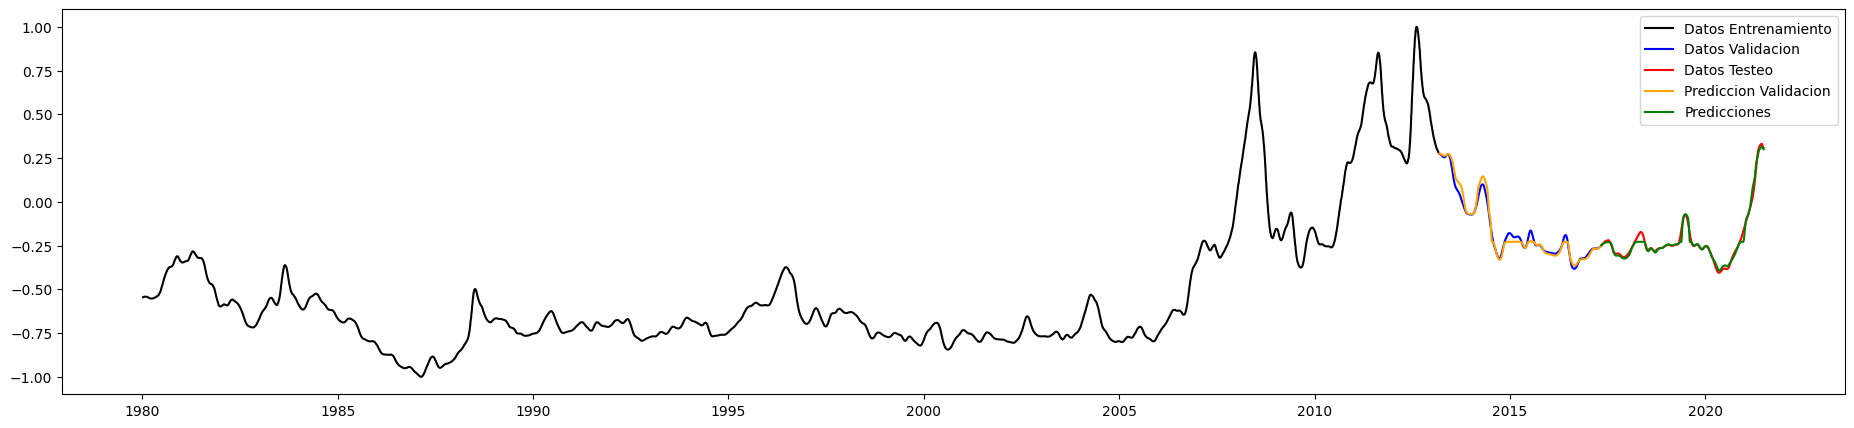

In [44]:
fig, ax = plt.subplots(figsize=(23, 5))
ax.plot(datos_entrenamiento_c1.index,datos_entrenamiento_c1.Precio_Cierre,color='black',label = 'Datos Entrenamiento')
ax.plot(datos_validacion_c1.index,datos_validacion_c1.Precio_Cierre,color='blue',label = 'Datos Validacion')
ax.plot(datos_testeo_c1.index,datos_testeo_c1.Precio_Cierre,color='red',label = 'Datos Testeo')
ax.plot(datos_validacion_c1.index,prediccion_validacion_c1,color='orange',label = 'Prediccion Validacion')
ax.plot(datos_testeo_c1.index,prediccion_testeo_c1 ,color='Green',label = 'Predicciones')
ax.legend(loc = 'upper right')
plt.show()

In [45]:
score = np.sqrt(mean_squared_error(prediccion_validacion_c1,datos_validacion_c1.Precio_Cierre))
print(score)

0.027477833


In [46]:
prediccion_validacion_c1 = componente_1_scaler.inverse_transform(prediccion_validacion_c1)
prediccion_testeo_c1 = componente_1_scaler.inverse_transform(prediccion_testeo_c1 )

# Modelamos el componente 2

In [47]:
componente_2_sup , componente_2_scaler = a_supervisado(componente_2)

In [48]:
datos_entrenamiento_c2, datos_validacion_c2, datos_testeo_c2, X_train, y_train, X_val, y_val, X_test, y_test = division_datos(componente_2_sup)

(12118, 1, 7) (12118,) (1514, 1, 7) (1514,) (1516, 1, 7) (1516,)


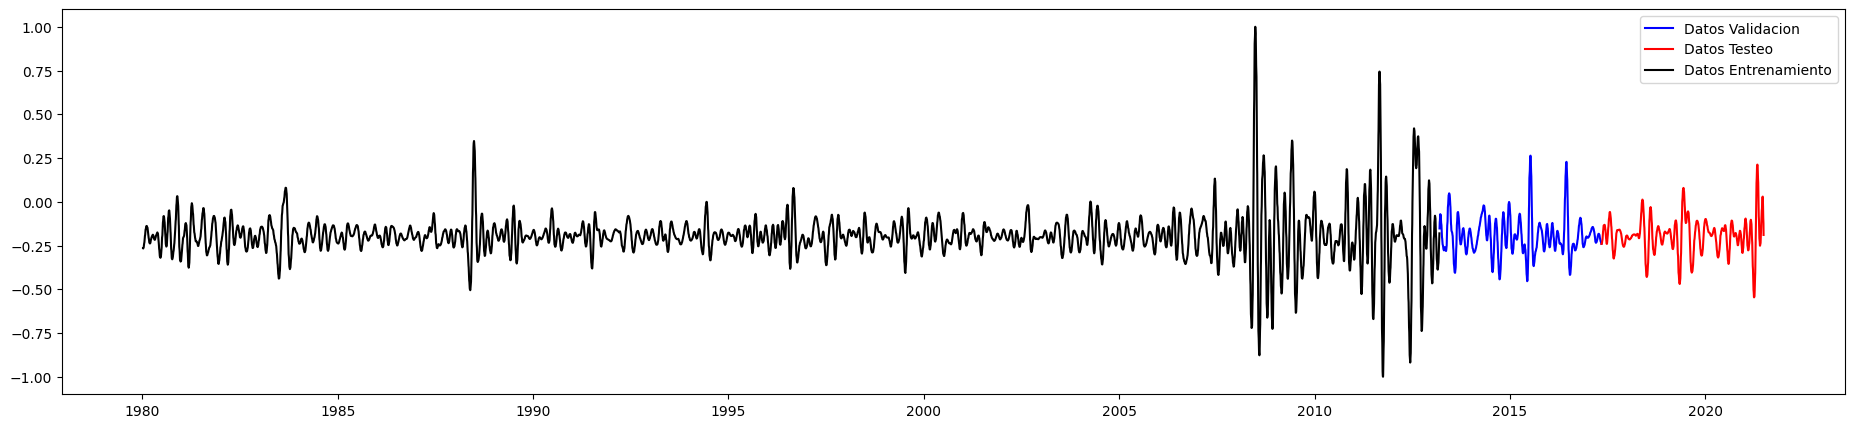

In [49]:
fig, ax = plt.subplots(figsize=(23, 5))
ax.plot(datos_validacion_c2.index,datos_validacion_c2.Precio_Cierre,color='blue',label = 'Datos Validacion')
ax.plot(datos_testeo_c2.index,datos_testeo_c2.Precio_Cierre,color='red',label = 'Datos Testeo')
ax.plot(datos_entrenamiento_c2.index,datos_entrenamiento_c2.Precio_Cierre,color='black',label = 'Datos Entrenamiento')
ax.legend(loc = 'upper right')
plt.show()

In [ ]:
# Crear un estudio Optuna
study = optuna.create_study(direction='minimize')

# Ejecutar la optimización de hiperparámetros
study.optimize(objective, n_trials=100)

# Obtener los mejores hiperparámetros
best_params = study.best_params
print("Mejores hiperparámetros:", best_params)

[I 2024-06-20 17:47:21,087] A new study created in memory with name: no-name-66cd8cbd-72a2-493c-8e3e-87f956eccb14


48/48 [==============================] - 1s 2ms/step


[I 2024-06-20 17:48:09,493] Trial 0 finished with value: 0.011477641761302948 and parameters: {'units': 30, 'n_layers': 1, 'units_0': 16, 'learning_rate': 0.06541481059315248}. Best is trial 0 with value: 0.011477641761302948.


48/48 [==============================] - 1s 3ms/step


[I 2024-06-20 17:48:55,721] Trial 1 finished with value: 0.010348341427743435 and parameters: {'units': 65, 'n_layers': 1, 'units_0': 43, 'learning_rate': 0.022037834568917246}. Best is trial 1 with value: 0.010348341427743435.


48/48 [==============================] - 2s 3ms/step


[I 2024-06-20 17:49:45,755] Trial 2 finished with value: 0.009674785658717155 and parameters: {'units': 30, 'n_layers': 2, 'units_0': 27, 'units_1': 28, 'learning_rate': 0.0024975125759590833}. Best is trial 2 with value: 0.009674785658717155.


48/48 [==============================] - 2s 4ms/step


[I 2024-06-20 17:50:26,569] Trial 3 finished with value: 0.013190473429858685 and parameters: {'units': 55, 'n_layers': 2, 'units_0': 19, 'units_1': 27, 'learning_rate': 0.0729028037257901}. Best is trial 2 with value: 0.009674785658717155.


48/48 [==============================] - 2s 5ms/step


[I 2024-06-20 17:51:09,775] Trial 4 finished with value: 0.014044994488358498 and parameters: {'units': 37, 'n_layers': 2, 'units_0': 48, 'units_1': 49, 'learning_rate': 0.04684929868589118}. Best is trial 2 with value: 0.009674785658717155.


48/48 [==============================] - 1s 4ms/step


[I 2024-06-20 17:51:50,510] Trial 5 finished with value: 0.012157264165580273 and parameters: {'units': 61, 'n_layers': 2, 'units_0': 29, 'units_1': 66, 'learning_rate': 0.030875033342005205}. Best is trial 2 with value: 0.009674785658717155.


48/48 [==============================] - 2s 4ms/step


[I 2024-06-20 17:52:24,711] Trial 6 finished with value: 0.014350415207445621 and parameters: {'units': 34, 'n_layers': 1, 'units_0': 69, 'learning_rate': 0.041699597164739984}. Best is trial 2 with value: 0.009674785658717155.


48/48 [==============================] - 1s 3ms/step


[I 2024-06-20 17:53:14,189] Trial 7 finished with value: 0.008764063939452171 and parameters: {'units': 15, 'n_layers': 2, 'units_0': 28, 'units_1': 39, 'learning_rate': 0.00445869436036727}. Best is trial 7 with value: 0.008764063939452171.


48/48 [==============================] - 2s 5ms/step


[I 2024-06-20 17:54:01,560] Trial 8 finished with value: 0.011666499078273773 and parameters: {'units': 36, 'n_layers': 1, 'units_0': 38, 'learning_rate': 0.09575045458580067}. Best is trial 7 with value: 0.008764063939452171.


48/48 [==============================] - 1s 3ms/step


[I 2024-06-20 17:54:51,355] Trial 9 finished with value: 0.012412789277732372 and parameters: {'units': 18, 'n_layers': 2, 'units_0': 38, 'units_1': 68, 'learning_rate': 0.08074545113549529}. Best is trial 7 with value: 0.008764063939452171.


48/48 [==============================] - 2s 4ms/step


[I 2024-06-20 17:55:41,619] Trial 10 finished with value: 0.009604337625205517 and parameters: {'units': 10, 'n_layers': 2, 'units_0': 8, 'units_1': 7, 'learning_rate': 0.002681963377297348}. Best is trial 7 with value: 0.008764063939452171.


48/48 [==============================] - 1s 3ms/step


[I 2024-06-20 17:56:19,381] Trial 11 finished with value: 0.009702257812023163 and parameters: {'units': 10, 'n_layers': 2, 'units_0': 8, 'units_1': 9, 'learning_rate': 0.0010177083763415564}. Best is trial 7 with value: 0.008764063939452171.


48/48 [==============================] - 8s 4ms/step


[I 2024-06-20 17:57:04,491] Trial 12 finished with value: 0.009842440485954285 and parameters: {'units': 17, 'n_layers': 2, 'units_0': 8, 'units_1': 44, 'learning_rate': 0.016222347477657478}. Best is trial 7 with value: 0.008764063939452171.


48/48 [==============================] - 2s 4ms/step


[I 2024-06-20 17:57:54,973] Trial 13 finished with value: 0.009062408469617367 and parameters: {'units': 10, 'n_layers': 2, 'units_0': 60, 'units_1': 7, 'learning_rate': 0.013473001502826237}. Best is trial 7 with value: 0.008764063939452171.


48/48 [==============================] - 2s 4ms/step


[I 2024-06-20 17:58:44,591] Trial 14 finished with value: 0.010285964235663414 and parameters: {'units': 23, 'n_layers': 2, 'units_0': 59, 'units_1': 30, 'learning_rate': 0.01822575874108352}. Best is trial 7 with value: 0.008764063939452171.


48/48 [==============================] - 2s 4ms/step


[I 2024-06-20 17:59:31,703] Trial 15 finished with value: 0.01285430695861578 and parameters: {'units': 45, 'n_layers': 2, 'units_0': 56, 'units_1': 18, 'learning_rate': 0.03223613378742629}. Best is trial 7 with value: 0.008764063939452171.


48/48 [==============================] - 2s 4ms/step


[I 2024-06-20 18:00:22,558] Trial 16 finished with value: 0.014487343840301037 and parameters: {'units': 22, 'n_layers': 2, 'units_0': 29, 'units_1': 51, 'learning_rate': 0.05865969154711909}. Best is trial 7 with value: 0.008764063939452171.


48/48 [==============================] - 1s 4ms/step


[I 2024-06-20 18:00:57,513] Trial 17 finished with value: 0.010413700714707375 and parameters: {'units': 47, 'n_layers': 1, 'units_0': 66, 'learning_rate': 0.013092286999932076}. Best is trial 7 with value: 0.008764063939452171.


48/48 [==============================] - 2s 4ms/step


[I 2024-06-20 18:01:49,394] Trial 18 finished with value: 0.012809286825358868 and parameters: {'units': 14, 'n_layers': 2, 'units_0': 50, 'units_1': 35, 'learning_rate': 0.029884972931386436}. Best is trial 7 with value: 0.008764063939452171.


48/48 [==============================] - 2s 3ms/step


[I 2024-06-20 18:02:38,333] Trial 19 finished with value: 0.00934539083391428 and parameters: {'units': 24, 'n_layers': 2, 'units_0': 61, 'units_1': 18, 'learning_rate': 0.010122147585723162}. Best is trial 7 with value: 0.008764063939452171.


48/48 [==============================] - 2s 5ms/step


[I 2024-06-20 18:03:27,278] Trial 20 finished with value: 0.013405458070337772 and parameters: {'units': 27, 'n_layers': 1, 'units_0': 21, 'learning_rate': 0.03964936382665902}. Best is trial 7 with value: 0.008764063939452171.


48/48 [==============================] - 3s 5ms/step


[I 2024-06-20 18:04:09,535] Trial 21 finished with value: 0.008621126413345337 and parameters: {'units': 21, 'n_layers': 2, 'units_0': 64, 'units_1': 18, 'learning_rate': 0.011292258369325646}. Best is trial 21 with value: 0.008621126413345337.


48/48 [==============================] - 2s 3ms/step


[I 2024-06-20 18:04:59,232] Trial 22 finished with value: 0.012437449768185616 and parameters: {'units': 15, 'n_layers': 2, 'units_0': 70, 'units_1': 17, 'learning_rate': 0.023985978992044465}. Best is trial 21 with value: 0.008621126413345337.


48/48 [==============================] - 2s 3ms/step


[I 2024-06-20 18:05:40,081] Trial 23 finished with value: 0.010242589749395847 and parameters: {'units': 19, 'n_layers': 2, 'units_0': 56, 'units_1': 12, 'learning_rate': 0.009397478460746676}. Best is trial 21 with value: 0.008621126413345337.


48/48 [==============================] - 2s 3ms/step


[I 2024-06-20 18:06:29,257] Trial 24 finished with value: 0.011537022888660431 and parameters: {'units': 10, 'n_layers': 2, 'units_0': 51, 'units_1': 42, 'learning_rate': 0.00770657447234318}. Best is trial 21 with value: 0.008621126413345337.


48/48 [==============================] - 1s 3ms/step


[I 2024-06-20 18:07:09,201] Trial 25 finished with value: 0.013297959230840206 and parameters: {'units': 21, 'n_layers': 2, 'units_0': 63, 'units_1': 23, 'learning_rate': 0.0208096822878606}. Best is trial 21 with value: 0.008621126413345337.


48/48 [==============================] - 2s 4ms/step


[I 2024-06-20 18:07:59,211] Trial 26 finished with value: 0.016717631369829178 and parameters: {'units': 14, 'n_layers': 2, 'units_0': 33, 'units_1': 36, 'learning_rate': 0.030028156401263224}. Best is trial 21 with value: 0.008621126413345337.


48/48 [==============================] - 1s 3ms/step


[I 2024-06-20 18:08:38,539] Trial 27 finished with value: 0.01121273823082447 and parameters: {'units': 42, 'n_layers': 2, 'units_0': 45, 'units_1': 57, 'learning_rate': 0.011360897199527339}. Best is trial 21 with value: 0.008621126413345337.


48/48 [==============================] - 1s 3ms/step


[I 2024-06-20 18:09:28,475] Trial 28 finished with value: 0.012473582290112972 and parameters: {'units': 29, 'n_layers': 2, 'units_0': 54, 'units_1': 13, 'learning_rate': 0.056421675150496384}. Best is trial 21 with value: 0.008621126413345337.


48/48 [==============================] - 1s 3ms/step


[I 2024-06-20 18:10:14,814] Trial 29 finished with value: 0.009654995985329151 and parameters: {'units': 26, 'n_layers': 1, 'units_0': 64, 'learning_rate': 0.0380790083394206}. Best is trial 21 with value: 0.008621126413345337.


48/48 [==============================] - 2s 5ms/step


[I 2024-06-20 18:11:05,395] Trial 30 finished with value: 0.0266056340187788 and parameters: {'units': 32, 'n_layers': 2, 'units_0': 14, 'units_1': 24, 'learning_rate': 0.02408185916985088}. Best is trial 21 with value: 0.008621126413345337.


48/48 [==============================] - 1s 3ms/step


[I 2024-06-20 18:11:41,839] Trial 31 finished with value: 0.010056824423372746 and parameters: {'units': 24, 'n_layers': 2, 'units_0': 63, 'units_1': 19, 'learning_rate': 0.006491791695021655}. Best is trial 21 with value: 0.008621126413345337.


48/48 [==============================] - 9s 5ms/step


[I 2024-06-20 18:12:28,643] Trial 32 finished with value: 0.010431144386529922 and parameters: {'units': 14, 'n_layers': 2, 'units_0': 61, 'units_1': 14, 'learning_rate': 0.00011806469984615604}. Best is trial 21 with value: 0.008621126413345337.


48/48 [==============================] - 2s 5ms/step


[I 2024-06-20 18:13:15,312] Trial 33 finished with value: 0.011084702797234058 and parameters: {'units': 21, 'n_layers': 2, 'units_0': 42, 'units_1': 33, 'learning_rate': 0.013745804767118544}. Best is trial 21 with value: 0.008621126413345337.


48/48 [==============================] - 2s 4ms/step


[I 2024-06-20 18:13:56,012] Trial 34 finished with value: 0.008920016698539257 and parameters: {'units': 17, 'n_layers': 2, 'units_0': 24, 'units_1': 7, 'learning_rate': 0.00706664657068082}. Best is trial 21 with value: 0.008621126413345337.


48/48 [==============================] - 2s 3ms/step


[I 2024-06-20 18:14:45,616] Trial 35 finished with value: 0.00892498716711998 and parameters: {'units': 13, 'n_layers': 2, 'units_0': 19, 'units_1': 8, 'learning_rate': 0.017614785523377044}. Best is trial 21 with value: 0.008621126413345337.


48/48 [==============================] - 2s 4ms/step


[I 2024-06-20 18:15:27,478] Trial 36 finished with value: 0.009724464267492294 and parameters: {'units': 17, 'n_layers': 2, 'units_0': 20, 'units_1': 11, 'learning_rate': 0.005594926795238602}. Best is trial 21 with value: 0.008621126413345337.


48/48 [==============================] - 2s 3ms/step


[I 2024-06-20 18:16:16,696] Trial 37 finished with value: 0.010374277830123901 and parameters: {'units': 52, 'n_layers': 2, 'units_0': 25, 'units_1': 40, 'learning_rate': 0.02327793554964703}. Best is trial 21 with value: 0.008621126413345337.


48/48 [==============================] - 1s 3ms/step


[I 2024-06-20 18:17:04,318] Trial 38 finished with value: 0.012185015715658665 and parameters: {'units': 64, 'n_layers': 1, 'units_0': 15, 'learning_rate': 0.019546977996973483}. Best is trial 21 with value: 0.008621126413345337.


48/48 [==============================] - 1s 3ms/step


[I 2024-06-20 18:17:52,963] Trial 39 finished with value: 0.015363524667918682 and parameters: {'units': 30, 'n_layers': 2, 'units_0': 33, 'units_1': 15, 'learning_rate': 0.0684008052443747}. Best is trial 21 with value: 0.008621126413345337.


48/48 [==============================] - 1s 3ms/step


[I 2024-06-20 18:18:42,923] Trial 40 finished with value: 0.012949896976351738 and parameters: {'units': 69, 'n_layers': 2, 'units_0': 24, 'units_1': 22, 'learning_rate': 0.05050699763250517}. Best is trial 21 with value: 0.008621126413345337.


48/48 [==============================] - 2s 5ms/step


[I 2024-06-20 18:19:31,977] Trial 41 finished with value: 0.009066416881978512 and parameters: {'units': 13, 'n_layers': 2, 'units_0': 33, 'units_1': 7, 'learning_rate': 0.015460203175476965}. Best is trial 21 with value: 0.008621126413345337.


48/48 [==============================] - 1s 4ms/step


[I 2024-06-20 18:20:10,226] Trial 42 finished with value: 0.009304824285209179 and parameters: {'units': 19, 'n_layers': 2, 'units_0': 18, 'units_1': 7, 'learning_rate': 0.006306243112766007}. Best is trial 21 with value: 0.008621126413345337.


48/48 [==============================] - 2s 5ms/step


[I 2024-06-20 18:21:00,324] Trial 43 finished with value: 0.010015004314482212 and parameters: {'units': 12, 'n_layers': 2, 'units_0': 23, 'units_1': 28, 'learning_rate': 0.002885880212643598}. Best is trial 21 with value: 0.008621126413345337.


48/48 [==============================] - 1s 3ms/step


[I 2024-06-20 18:21:36,293] Trial 44 finished with value: 0.01328094769269228 and parameters: {'units': 17, 'n_layers': 2, 'units_0': 29, 'units_1': 11, 'learning_rate': 0.08232850130338049}. Best is trial 21 with value: 0.008621126413345337.


48/48 [==============================] - 2s 3ms/step


[I 2024-06-20 18:22:17,494] Trial 45 finished with value: 0.012498348951339722 and parameters: {'units': 11, 'n_layers': 2, 'units_0': 14, 'units_1': 46, 'learning_rate': 0.027044628740413464}. Best is trial 21 with value: 0.008621126413345337.


48/48 [==============================] - 1s 3ms/step


[I 2024-06-20 18:22:53,415] Trial 46 finished with value: 0.010649831965565681 and parameters: {'units': 16, 'n_layers': 2, 'units_0': 12, 'units_1': 11, 'learning_rate': 0.016781416770643057}. Best is trial 21 with value: 0.008621126413345337.


48/48 [==============================] - 1s 3ms/step


[I 2024-06-20 18:23:30,302] Trial 47 finished with value: 0.011060015298426151 and parameters: {'units': 20, 'n_layers': 2, 'units_0': 35, 'units_1': 9, 'learning_rate': 0.011107331207526763}. Best is trial 21 with value: 0.008621126413345337.


48/48 [==============================] - 2s 5ms/step


[I 2024-06-20 18:24:19,025] Trial 48 finished with value: 0.013261477462947369 and parameters: {'units': 39, 'n_layers': 2, 'units_0': 27, 'units_1': 53, 'learning_rate': 0.0340039962876536}. Best is trial 21 with value: 0.008621126413345337.


48/48 [==============================] - 1s 3ms/step


[I 2024-06-20 18:24:57,599] Trial 49 finished with value: 0.009562094695866108 and parameters: {'units': 10, 'n_layers': 2, 'units_0': 67, 'units_1': 15, 'learning_rate': 0.004557789146140207}. Best is trial 21 with value: 0.008621126413345337.


48/48 [==============================] - 2s 4ms/step


[I 2024-06-20 18:25:35,141] Trial 50 finished with value: 0.015869835391640663 and parameters: {'units': 13, 'n_layers': 2, 'units_0': 41, 'units_1': 7, 'learning_rate': 0.045045354518224945}. Best is trial 21 with value: 0.008621126413345337.


48/48 [==============================] - 1s 3ms/step


[I 2024-06-20 18:26:11,268] Trial 51 finished with value: 0.01205345056951046 and parameters: {'units': 13, 'n_layers': 2, 'units_0': 35, 'units_1': 7, 'learning_rate': 0.016271610715570456}. Best is trial 21 with value: 0.008621126413345337.


48/48 [==============================] - 2s 5ms/step


[I 2024-06-20 18:27:01,637] Trial 52 finished with value: 0.009774639271199703 and parameters: {'units': 16, 'n_layers': 2, 'units_0': 32, 'units_1': 9, 'learning_rate': 0.013379722241544774}. Best is trial 21 with value: 0.008621126413345337.


48/48 [==============================] - 1s 3ms/step


[I 2024-06-20 18:27:37,740] Trial 53 finished with value: 0.01009698398411274 and parameters: {'units': 12, 'n_layers': 2, 'units_0': 18, 'units_1': 21, 'learning_rate': 0.0003016661747959268}. Best is trial 21 with value: 0.008621126413345337.


48/48 [==============================] - 1s 3ms/step


[I 2024-06-20 18:28:16,618] Trial 54 finished with value: 0.01286374032497406 and parameters: {'units': 18, 'n_layers': 2, 'units_0': 27, 'units_1': 31, 'learning_rate': 0.01901643125475433}. Best is trial 21 with value: 0.008621126413345337.


48/48 [==============================] - 2s 5ms/step


[I 2024-06-20 18:29:07,763] Trial 55 finished with value: 0.012778881005942822 and parameters: {'units': 26, 'n_layers': 2, 'units_0': 22, 'units_1': 26, 'learning_rate': 0.09867190474835853}. Best is trial 21 with value: 0.008621126413345337.


48/48 [==============================] - 2s 4ms/step


[I 2024-06-20 18:29:57,498] Trial 56 finished with value: 0.01534179039299488 and parameters: {'units': 23, 'n_layers': 2, 'units_0': 30, 'units_1': 15, 'learning_rate': 0.027064084423599106}. Best is trial 21 with value: 0.008621126413345337.


48/48 [==============================] - 1s 3ms/step


[I 2024-06-20 18:30:30,752] Trial 57 finished with value: 0.008056228049099445 and parameters: {'units': 15, 'n_layers': 1, 'units_0': 39, 'learning_rate': 0.008396391332945353}. Best is trial 57 with value: 0.008056228049099445.


48/48 [==============================] - 1s 3ms/step


[I 2024-06-20 18:31:18,672] Trial 58 finished with value: 0.009669368155300617 and parameters: {'units': 15, 'n_layers': 1, 'units_0': 11, 'learning_rate': 0.009141626246154212}. Best is trial 57 with value: 0.008056228049099445.


48/48 [==============================] - 1s 4ms/step


[I 2024-06-20 18:32:05,357] Trial 59 finished with value: 0.009656408801674843 and parameters: {'units': 20, 'n_layers': 1, 'units_0': 48, 'learning_rate': 0.008136766279123747}. Best is trial 57 with value: 0.008056228049099445.


48/48 [==============================] - 2s 5ms/step


[I 2024-06-20 18:32:39,735] Trial 60 finished with value: 0.009789280593395233 and parameters: {'units': 35, 'n_layers': 1, 'units_0': 59, 'learning_rate': 0.0038406467469693263}. Best is trial 57 with value: 0.008056228049099445.


48/48 [==============================] - 2s 5ms/step


[I 2024-06-20 18:33:10,258] Trial 61 finished with value: 0.009737895801663399 and parameters: {'units': 10, 'n_layers': 1, 'units_0': 36, 'learning_rate': 0.01582032666478741}. Best is trial 57 with value: 0.008056228049099445.


48/48 [==============================] - 1s 3ms/step


[I 2024-06-20 18:33:58,535] Trial 62 finished with value: 0.010667957365512848 and parameters: {'units': 15, 'n_layers': 2, 'units_0': 26, 'units_1': 10, 'learning_rate': 0.013387316651992442}. Best is trial 57 with value: 0.008056228049099445.


48/48 [==============================] - 1s 3ms/step


[I 2024-06-20 18:34:29,265] Trial 63 finished with value: 0.009902846068143845 and parameters: {'units': 12, 'n_layers': 1, 'units_0': 68, 'learning_rate': 0.009801006624471156}. Best is trial 57 with value: 0.008056228049099445.


48/48 [==============================] - 2s 3ms/step


[I 2024-06-20 18:35:10,758] Trial 64 finished with value: 0.012080092914402485 and parameters: {'units': 19, 'n_layers': 2, 'units_0': 39, 'units_1': 37, 'learning_rate': 0.021181109347951265}. Best is trial 57 with value: 0.008056228049099445.


48/48 [==============================] - 2s 3ms/step


[I 2024-06-20 18:35:49,193] Trial 65 finished with value: 0.00983289536088705 and parameters: {'units': 17, 'n_layers': 2, 'units_0': 44, 'units_1': 17, 'learning_rate': 0.015750061796140163}. Best is trial 57 with value: 0.008056228049099445.


48/48 [==============================] - 2s 4ms/step


[I 2024-06-20 18:36:27,230] Trial 66 finished with value: 0.014415672980248928 and parameters: {'units': 14, 'n_layers': 2, 'units_0': 31, 'units_1': 13, 'learning_rate': 0.025858502219629993}. Best is trial 57 with value: 0.008056228049099445.


48/48 [==============================] - 2s 4ms/step


[I 2024-06-20 18:37:05,164] Trial 67 finished with value: 0.009872673079371452 and parameters: {'units': 22, 'n_layers': 2, 'units_0': 21, 'units_1': 7, 'learning_rate': 0.003484625507756675}. Best is trial 57 with value: 0.008056228049099445.


48/48 [==============================] - 1s 3ms/step


[I 2024-06-20 18:37:34,393] Trial 68 finished with value: 0.010895989835262299 and parameters: {'units': 12, 'n_layers': 1, 'units_0': 55, 'learning_rate': 0.011164503600018343}. Best is trial 57 with value: 0.008056228049099445.


48/48 [==============================] - 2s 3ms/step


[I 2024-06-20 18:38:14,037] Trial 69 finished with value: 0.009712787345051765 and parameters: {'units': 18, 'n_layers': 2, 'units_0': 59, 'units_1': 20, 'learning_rate': 0.007149933164209636}. Best is trial 57 with value: 0.008056228049099445.


48/48 [==============================] - 2s 5ms/step


[I 2024-06-20 18:38:54,291] Trial 70 finished with value: 0.013414823450148106 and parameters: {'units': 52, 'n_layers': 2, 'units_0': 53, 'units_1': 62, 'learning_rate': 0.035467807332976595}. Best is trial 57 with value: 0.008056228049099445.


48/48 [==============================] - 2s 3ms/step


[I 2024-06-20 18:39:33,731] Trial 71 finished with value: 0.00932491384446621 and parameters: {'units': 19, 'n_layers': 2, 'units_0': 18, 'units_1': 9, 'learning_rate': 0.006248424242187202}. Best is trial 57 with value: 0.008056228049099445.


48/48 [==============================] - 2s 4ms/step


[I 2024-06-20 18:40:25,131] Trial 72 finished with value: 0.009546061046421528 and parameters: {'units': 15, 'n_layers': 2, 'units_0': 17, 'units_1': 7, 'learning_rate': 0.013967547007369723}. Best is trial 57 with value: 0.008056228049099445.


48/48 [==============================] - 1s 3ms/step


[I 2024-06-20 18:41:01,101] Trial 73 finished with value: 0.009872982278466225 and parameters: {'units': 24, 'n_layers': 2, 'units_0': 20, 'units_1': 45, 'learning_rate': 0.001768090887460775}. Best is trial 57 with value: 0.008056228049099445.


48/48 [==============================] - 1s 3ms/step


[I 2024-06-20 18:41:51,134] Trial 74 finished with value: 0.012493536807596684 and parameters: {'units': 21, 'n_layers': 2, 'units_0': 23, 'units_1': 13, 'learning_rate': 0.019535200906055664}. Best is trial 57 with value: 0.008056228049099445.


48/48 [==============================] - 1s 3ms/step


[I 2024-06-20 18:42:27,712] Trial 75 finished with value: 0.010001003742218018 and parameters: {'units': 13, 'n_layers': 2, 'units_0': 65, 'units_1': 9, 'learning_rate': 0.006132947049830642}. Best is trial 57 with value: 0.008056228049099445.


48/48 [==============================] - 1s 3ms/step


[I 2024-06-20 18:43:17,564] Trial 76 finished with value: 0.009518738836050034 and parameters: {'units': 10, 'n_layers': 2, 'units_0': 25, 'units_1': 17, 'learning_rate': 0.01133031504477608}. Best is trial 57 with value: 0.008056228049099445.


48/48 [==============================] - 3s 6ms/step


[I 2024-06-20 18:43:56,922] Trial 77 finished with value: 0.010540000163018703 and parameters: {'units': 32, 'n_layers': 2, 'units_0': 27, 'units_1': 39, 'learning_rate': 0.08949955649282818}. Best is trial 57 with value: 0.008056228049099445.


48/48 [==============================] - 1s 3ms/step


[I 2024-06-20 18:44:34,865] Trial 78 finished with value: 0.01016931515187025 and parameters: {'units': 28, 'n_layers': 2, 'units_0': 11, 'units_1': 12, 'learning_rate': 0.022842335424736272}. Best is trial 57 with value: 0.008056228049099445.


48/48 [==============================] - 1s 3ms/step


[I 2024-06-20 18:45:13,326] Trial 79 finished with value: 0.014529530890285969 and parameters: {'units': 16, 'n_layers': 2, 'units_0': 70, 'units_1': 42, 'learning_rate': 0.01765419192280953}. Best is trial 57 with value: 0.008056228049099445.


48/48 [==============================] - 3s 4ms/step


[I 2024-06-20 18:45:51,322] Trial 80 finished with value: 0.010526370257139206 and parameters: {'units': 25, 'n_layers': 2, 'units_0': 15, 'units_1': 7, 'learning_rate': 0.00877775832549707}. Best is trial 57 with value: 0.008056228049099445.


48/48 [==============================] - 1s 3ms/step


[I 2024-06-20 18:46:30,737] Trial 81 finished with value: 0.009874998591840267 and parameters: {'units': 19, 'n_layers': 2, 'units_0': 20, 'units_1': 10, 'learning_rate': 0.00623429915090138}. Best is trial 57 with value: 0.008056228049099445.


48/48 [==============================] - 2s 4ms/step


[I 2024-06-20 18:47:07,936] Trial 82 finished with value: 0.010031120851635933 and parameters: {'units': 18, 'n_layers': 2, 'units_0': 16, 'units_1': 9, 'learning_rate': 0.004129315670739164}. Best is trial 57 with value: 0.008056228049099445.


48/48 [==============================] - 2s 3ms/step


[I 2024-06-20 18:48:07,596] Trial 83 finished with value: 0.008219153620302677 and parameters: {'units': 20, 'n_layers': 2, 'units_0': 29, 'units_1': 16, 'learning_rate': 0.012800446146991978}. Best is trial 57 with value: 0.008056228049099445.


48/48 [==============================] - 2s 3ms/step


[I 2024-06-20 18:48:56,503] Trial 84 finished with value: 0.009577267803251743 and parameters: {'units': 22, 'n_layers': 2, 'units_0': 29, 'units_1': 15, 'learning_rate': 0.01240358766415799}. Best is trial 57 with value: 0.008056228049099445.


48/48 [==============================] - 1s 4ms/step


[I 2024-06-20 18:49:39,563] Trial 85 finished with value: 0.010870816186070442 and parameters: {'units': 14, 'n_layers': 2, 'units_0': 33, 'units_1': 48, 'learning_rate': 0.015589143261486787}. Best is trial 57 with value: 0.008056228049099445.


48/48 [==============================] - 2s 5ms/step


[I 2024-06-20 18:50:30,272] Trial 86 finished with value: 0.009163009002804756 and parameters: {'units': 16, 'n_layers': 2, 'units_0': 36, 'units_1': 33, 'learning_rate': 0.009000947677191305}. Best is trial 57 with value: 0.008056228049099445.


48/48 [==============================] - 2s 4ms/step


[I 2024-06-20 18:51:14,266] Trial 87 finished with value: 0.017465339973568916 and parameters: {'units': 11, 'n_layers': 2, 'units_0': 37, 'units_1': 70, 'learning_rate': 0.020985881135479254}. Best is trial 57 with value: 0.008056228049099445.


48/48 [==============================] - 2s 5ms/step


[I 2024-06-20 18:51:55,210] Trial 88 finished with value: 0.009907746687531471 and parameters: {'units': 16, 'n_layers': 2, 'units_0': 34, 'units_1': 24, 'learning_rate': 0.010127391616989858}. Best is trial 57 with value: 0.008056228049099445.


48/48 [==============================] - 1s 3ms/step


[I 2024-06-20 18:52:34,489] Trial 89 finished with value: 0.010588179342448711 and parameters: {'units': 12, 'n_layers': 2, 'units_0': 40, 'units_1': 34, 'learning_rate': 0.00014859574350990258}. Best is trial 57 with value: 0.008056228049099445.


48/48 [==============================] - 1s 3ms/step


[I 2024-06-20 18:53:15,309] Trial 90 finished with value: 0.010461092926561832 and parameters: {'units': 17, 'n_layers': 2, 'units_0': 46, 'units_1': 42, 'learning_rate': 0.018561565586605194}. Best is trial 57 with value: 0.008056228049099445.


48/48 [==============================] - 2s 4ms/step


[I 2024-06-20 18:54:05,808] Trial 91 finished with value: 0.009497067891061306 and parameters: {'units': 20, 'n_layers': 2, 'units_0': 31, 'units_1': 31, 'learning_rate': 0.007847465801361189}. Best is trial 57 with value: 0.008056228049099445.


48/48 [==============================] - 1s 3ms/step


[I 2024-06-20 18:54:41,406] Trial 92 finished with value: 0.009132561273872852 and parameters: {'units': 14, 'n_layers': 2, 'units_0': 25, 'units_1': 12, 'learning_rate': 0.002612931477233788}. Best is trial 57 with value: 0.008056228049099445.


48/48 [==============================] - 1s 3ms/step


[I 2024-06-20 18:55:21,493] Trial 93 finished with value: 0.009867035783827305 and parameters: {'units': 13, 'n_layers': 2, 'units_0': 28, 'units_1': 12, 'learning_rate': 0.001808704850806423}. Best is trial 57 with value: 0.008056228049099445.


48/48 [==============================] - 3s 6ms/step


[I 2024-06-20 18:56:01,603] Trial 94 finished with value: 0.010521535761654377 and parameters: {'units': 58, 'n_layers': 2, 'units_0': 24, 'units_1': 19, 'learning_rate': 0.013714104734091279}. Best is trial 57 with value: 0.008056228049099445.


48/48 [==============================] - 2s 3ms/step


[I 2024-06-20 18:56:41,971] Trial 95 finished with value: 0.00932854413986206 and parameters: {'units': 11, 'n_layers': 2, 'units_0': 38, 'units_1': 17, 'learning_rate': 0.0040534094565871474}. Best is trial 57 with value: 0.008056228049099445.


48/48 [==============================] - 2s 4ms/step


[I 2024-06-20 18:57:14,523] Trial 96 finished with value: 0.014303896576166153 and parameters: {'units': 15, 'n_layers': 1, 'units_0': 61, 'learning_rate': 0.06102412272555923}. Best is trial 57 with value: 0.008056228049099445.


48/48 [==============================] - 2s 4ms/step


[I 2024-06-20 18:58:04,509] Trial 97 finished with value: 0.009832070209085941 and parameters: {'units': 16, 'n_layers': 2, 'units_0': 31, 'units_1': 14, 'learning_rate': 0.014859038767506345}. Best is trial 57 with value: 0.008056228049099445.


48/48 [==============================] - 3s 5ms/step


[I 2024-06-20 18:58:55,890] Trial 98 finished with value: 0.009718574583530426 and parameters: {'units': 44, 'n_layers': 2, 'units_0': 28, 'units_1': 11, 'learning_rate': 0.009250487481080615}. Best is trial 57 with value: 0.008056228049099445.


48/48 [==============================] - 1s 3ms/step


[I 2024-06-20 18:59:33,516] Trial 99 finished with value: 0.009680674411356449 and parameters: {'units': 13, 'n_layers': 2, 'units_0': 26, 'units_1': 28, 'learning_rate': 0.011451146897505243}. Best is trial 57 with value: 0.008056228049099445.


Mejores hiperparámetros: {'units': 15, 'n_layers': 1, 'units_0': 39, 'learning_rate': 0.008396391332945353}


In [50]:
def modeloRR_c2():
  modelo = Sequential()
  modelo.add(LSTM(units=15, input_shape=(1,7), activation='tanh', return_sequences=True))
  modelo.add(LSTM(units=39,  activation='tanh', return_sequences=False))
  modelo.add(Dense(units=1))
  modelo.compile(optimizer=tf.keras.optimizers.RMSprop( 0.00839), loss='mse')
  return modelo

In [51]:
modelo = modeloRR_c2()
modelo.fit(X_train,y_train,epochs=40,batch_size=7)

Epoch 1/40
1732/1732 [==============================] - 14s 6ms/step - loss: 0.0014
Epoch 2/40
1732/1732 [==============================] - 11s 6ms/step - loss: 5.1784e-04
Epoch 3/40
1732/1732 [==============================] - 10s 6ms/step - loss: 4.0889e-04
Epoch 4/40
1732/1732 [==============================] - 10s 6ms/step - loss: 3.2786e-04
Epoch 5/40
1732/1732 [==============================] - 9s 5ms/step - loss: 2.8098e-04
Epoch 6/40
1732/1732 [==============================] - 10s 6ms/step - loss: 2.4143e-04
Epoch 7/40
1732/1732 [==============================] - 9s 5ms/step - loss: 2.3097e-04
Epoch 8/40
1732/1732 [==============================] - 10s 6ms/step - loss: 2.0106e-04
Epoch 9/40
1732/1732 [==============================] - 10s 6ms/step - loss: 1.9398e-04
Epoch 10/40
1732/1732 [==============================] - 8s 5ms/step - loss: 1.7929e-04
Epoch 11/40
1732/1732 [==============================] - 10s 6ms/step - loss: 1.6932e-04
Epoch 12/40
1732/1732 [==============

In [52]:
prediccion_validacion_c2 = modelo.predict(X_val)
prediccion_testeo_c2 = modelo.predict(X_test)

48/48 [==============================] - 0s 3ms/step


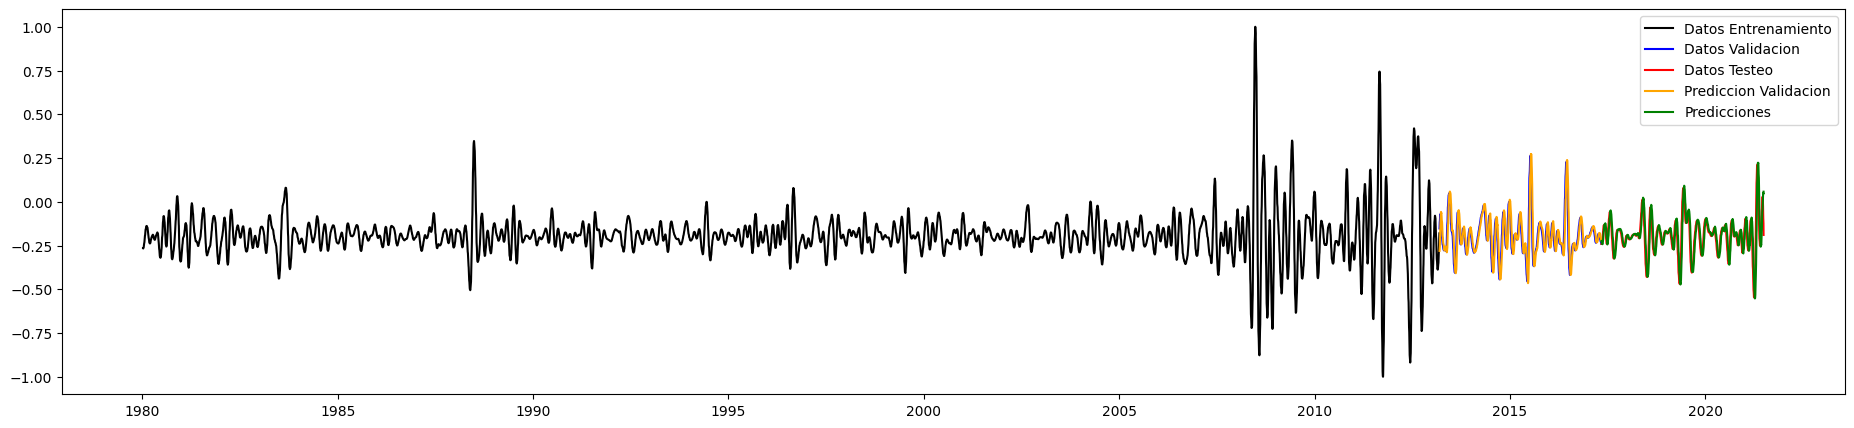

In [53]:
fig, ax = plt.subplots(figsize=(23, 5))
ax.plot(datos_entrenamiento_c2.index,datos_entrenamiento_c2.Precio_Cierre,color='black',label = 'Datos Entrenamiento')
ax.plot(datos_validacion_c2.index,datos_validacion_c2.Precio_Cierre,color='blue',label = 'Datos Validacion')
ax.plot(datos_testeo_c2.index,datos_testeo_c2.Precio_Cierre,color='red',label = 'Datos Testeo')
ax.plot(datos_validacion_c2.index,prediccion_validacion_c2,color='orange',label = 'Prediccion Validacion')
ax.plot(datos_testeo_c2.index,prediccion_testeo_c2 ,color='Green',label = 'Predicciones')
ax.legend(loc = 'upper right')
plt.show()

In [54]:
score = np.sqrt(mean_squared_error(prediccion_validacion_c2,datos_validacion_c2.Precio_Cierre))
print(score)

0.06571831


In [55]:
prediccion_validacion_c2 = componente_2_scaler.inverse_transform(prediccion_validacion_c2)
prediccion_testeo_c2 = componente_2_scaler.inverse_transform(prediccion_testeo_c2 )

# Modelado Componente 3

In [56]:
componente_3_sup , componente_3_scaler = a_supervisado(componente_3)

In [57]:
datos_entrenamiento_c3, datos_validacion_c3, datos_testeo_c3, X_train, y_train, X_val, y_val, X_test, y_test = division_datos(componente_3_sup)

(12118, 1, 7) (12118,) (1514, 1, 7) (1514,) (1516, 1, 7) (1516,)


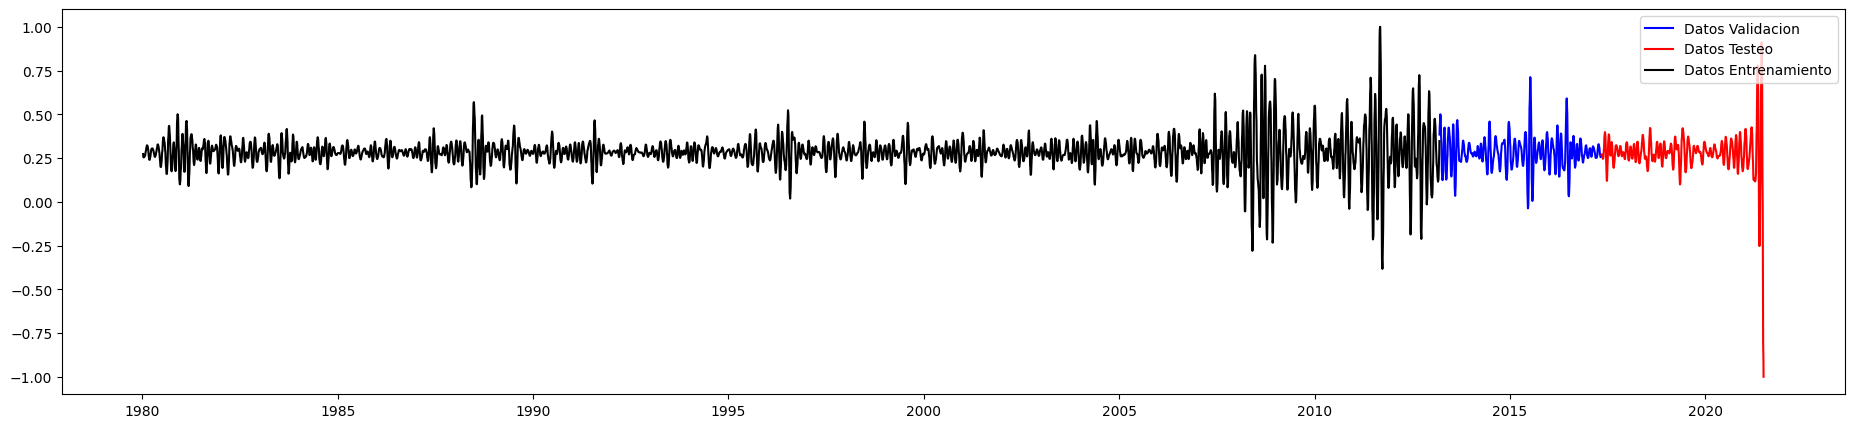

In [58]:
fig, ax = plt.subplots(figsize=(23, 5))
ax.plot(datos_validacion_c3.index,datos_validacion_c3.Precio_Cierre,color='blue',label = 'Datos Validacion')
ax.plot(datos_testeo_c3.index,datos_testeo_c3.Precio_Cierre,color='red',label = 'Datos Testeo')
ax.plot(datos_entrenamiento_c3.index,datos_entrenamiento_c3.Precio_Cierre,color='black',label = 'Datos Entrenamiento')
ax.legend(loc = 'upper right')
plt.show()

In [ ]:
# Crear un estudio Optuna
study = optuna.create_study(direction='minimize')

# Ejecutar la optimización de hiperparámetros
study.optimize(objective, n_trials=100)

# Obtener los mejores hiperparámetros
best_params = study.best_params
print("Mejores hiperparámetros:", best_params)

[I 2024-06-20 19:40:32,521] A new study created in memory with name: no-name-2b6c107b-fdd2-4ab8-bc9c-d8a9b9febf93


48/48 [==============================] - 2s 3ms/step


[I 2024-06-20 19:41:23,012] Trial 0 finished with value: 0.017413707450032234 and parameters: {'units': 29, 'n_layers': 2, 'units_0': 45, 'units_1': 7, 'learning_rate': 0.06019760585668}. Best is trial 0 with value: 0.017413707450032234.


48/48 [==============================] - 1s 3ms/step


[I 2024-06-20 19:41:52,792] Trial 1 finished with value: 0.007332935463637114 and parameters: {'units': 33, 'n_layers': 1, 'units_0': 65, 'learning_rate': 0.012978574809292995}. Best is trial 1 with value: 0.007332935463637114.


48/48 [==============================] - 1s 3ms/step


[I 2024-06-20 19:42:24,224] Trial 2 finished with value: 0.00690020015463233 and parameters: {'units': 60, 'n_layers': 1, 'units_0': 48, 'learning_rate': 0.01467948994633859}. Best is trial 2 with value: 0.00690020015463233.


48/48 [==============================] - 3s 5ms/step


[I 2024-06-20 19:43:15,629] Trial 3 finished with value: 0.02894887514412403 and parameters: {'units': 61, 'n_layers': 2, 'units_0': 46, 'units_1': 23, 'learning_rate': 0.05376607762463037}. Best is trial 2 with value: 0.00690020015463233.


48/48 [==============================] - 1s 2ms/step


[I 2024-06-20 19:43:46,412] Trial 4 finished with value: 0.011973345652222633 and parameters: {'units': 31, 'n_layers': 1, 'units_0': 65, 'learning_rate': 0.026058998535766945}. Best is trial 2 with value: 0.00690020015463233.


48/48 [==============================] - 1s 3ms/step


[I 2024-06-20 19:44:23,853] Trial 5 finished with value: 0.008570252917706966 and parameters: {'units': 40, 'n_layers': 2, 'units_0': 50, 'units_1': 26, 'learning_rate': 0.036496484929721414}. Best is trial 2 with value: 0.00690020015463233.


48/48 [==============================] - 1s 4ms/step


[I 2024-06-20 19:44:54,984] Trial 6 finished with value: 0.03988233581185341 and parameters: {'units': 16, 'n_layers': 1, 'units_0': 28, 'learning_rate': 0.09411920982424167}. Best is trial 2 with value: 0.00690020015463233.


48/48 [==============================] - 2s 3ms/step


[I 2024-06-20 19:45:44,968] Trial 7 finished with value: 0.008264749310910702 and parameters: {'units': 43, 'n_layers': 2, 'units_0': 17, 'units_1': 19, 'learning_rate': 0.012633448126644504}. Best is trial 2 with value: 0.00690020015463233.


48/48 [==============================] - 1s 3ms/step


[I 2024-06-20 19:46:35,031] Trial 8 finished with value: 0.041665080934762955 and parameters: {'units': 29, 'n_layers': 2, 'units_0': 61, 'units_1': 8, 'learning_rate': 0.08709403720342054}. Best is trial 2 with value: 0.00690020015463233.


48/48 [==============================] - 2s 3ms/step


[I 2024-06-20 19:47:26,073] Trial 9 finished with value: 0.008545218035578728 and parameters: {'units': 55, 'n_layers': 2, 'units_0': 34, 'units_1': 39, 'learning_rate': 0.01448619516113017}. Best is trial 2 with value: 0.00690020015463233.


48/48 [==============================] - 1s 3ms/step


[I 2024-06-20 19:48:14,899] Trial 10 finished with value: 0.008499052375555038 and parameters: {'units': 68, 'n_layers': 1, 'units_0': 7, 'learning_rate': 0.07183129161666935}. Best is trial 2 with value: 0.00690020015463233.


48/48 [==============================] - 1s 3ms/step


[I 2024-06-20 19:48:46,304] Trial 11 finished with value: 0.006638668477535248 and parameters: {'units': 50, 'n_layers': 1, 'units_0': 70, 'learning_rate': 0.0008681310110708086}. Best is trial 11 with value: 0.006638668477535248.


48/48 [==============================] - 1s 3ms/step


[I 2024-06-20 19:49:32,674] Trial 12 finished with value: 0.006574746686965227 and parameters: {'units': 52, 'n_layers': 1, 'units_0': 56, 'learning_rate': 0.0018011112519646095}. Best is trial 12 with value: 0.006574746686965227.


48/48 [==============================] - 2s 5ms/step


[I 2024-06-20 19:50:07,218] Trial 13 finished with value: 0.006663612090051174 and parameters: {'units': 49, 'n_layers': 1, 'units_0': 70, 'learning_rate': 0.0013022198730894483}. Best is trial 12 with value: 0.006574746686965227.


48/48 [==============================] - 1s 4ms/step


[I 2024-06-20 19:50:38,220] Trial 14 finished with value: 0.008641978725790977 and parameters: {'units': 50, 'n_layers': 1, 'units_0': 57, 'learning_rate': 0.03841048470587677}. Best is trial 12 with value: 0.006574746686965227.


48/48 [==============================] - 1s 3ms/step


[I 2024-06-20 19:51:13,039] Trial 15 finished with value: 0.0069417813792824745 and parameters: {'units': 70, 'n_layers': 1, 'units_0': 54, 'learning_rate': 0.00202050986696046}. Best is trial 12 with value: 0.006574746686965227.


48/48 [==============================] - 1s 3ms/step


[I 2024-06-20 19:51:59,302] Trial 16 finished with value: 0.008639968931674957 and parameters: {'units': 42, 'n_layers': 1, 'units_0': 40, 'learning_rate': 0.037942359009462086}. Best is trial 12 with value: 0.006574746686965227.


48/48 [==============================] - 2s 5ms/step


[I 2024-06-20 19:52:47,279] Trial 17 finished with value: 0.00861224066466093 and parameters: {'units': 13, 'n_layers': 1, 'units_0': 68, 'learning_rate': 0.025312898135463627}. Best is trial 12 with value: 0.006574746686965227.


48/48 [==============================] - 1s 3ms/step


[I 2024-06-20 19:53:17,815] Trial 18 finished with value: 0.006637460086494684 and parameters: {'units': 52, 'n_layers': 1, 'units_0': 58, 'learning_rate': 0.0006068713256778199}. Best is trial 12 with value: 0.006574746686965227.


48/48 [==============================] - 1s 3ms/step


[I 2024-06-20 19:53:49,628] Trial 19 finished with value: 0.00709331501275301 and parameters: {'units': 62, 'n_layers': 1, 'units_0': 57, 'learning_rate': 0.026434319069505493}. Best is trial 12 with value: 0.006574746686965227.


48/48 [==============================] - 1s 3ms/step


[I 2024-06-20 19:54:37,231] Trial 20 finished with value: 0.01031976006925106 and parameters: {'units': 57, 'n_layers': 1, 'units_0': 32, 'learning_rate': 0.06982904440469917}. Best is trial 12 with value: 0.006574746686965227.


48/48 [==============================] - 1s 3ms/step


[I 2024-06-20 19:55:08,768] Trial 21 finished with value: 0.006522726733237505 and parameters: {'units': 50, 'n_layers': 1, 'units_0': 61, 'learning_rate': 0.00026324021423066173}. Best is trial 21 with value: 0.006522726733237505.


48/48 [==============================] - 1s 3ms/step


[I 2024-06-20 19:55:56,660] Trial 22 finished with value: 0.00840065348893404 and parameters: {'units': 46, 'n_layers': 1, 'units_0': 61, 'learning_rate': 0.008695986111402093}. Best is trial 21 with value: 0.006522726733237505.


48/48 [==============================] - 1s 3ms/step


[I 2024-06-20 19:56:27,342] Trial 23 finished with value: 0.007774913217872381 and parameters: {'units': 53, 'n_layers': 1, 'units_0': 54, 'learning_rate': 0.020488458966796713}. Best is trial 21 with value: 0.006522726733237505.


48/48 [==============================] - 1s 3ms/step


[I 2024-06-20 19:57:13,848] Trial 24 finished with value: 0.006994772702455521 and parameters: {'units': 36, 'n_layers': 1, 'units_0': 61, 'learning_rate': 0.006513441244697732}. Best is trial 21 with value: 0.006522726733237505.


48/48 [==============================] - 1s 3ms/step


[I 2024-06-20 19:57:44,151] Trial 25 finished with value: 0.008121727034449577 and parameters: {'units': 65, 'n_layers': 1, 'units_0': 40, 'learning_rate': 0.018089574310083262}. Best is trial 21 with value: 0.006522726733237505.


48/48 [==============================] - 3s 5ms/step


[I 2024-06-20 19:58:16,405] Trial 26 finished with value: 0.00914117880165577 and parameters: {'units': 45, 'n_layers': 1, 'units_0': 51, 'learning_rate': 0.03264612620609151}. Best is trial 21 with value: 0.006522726733237505.


48/48 [==============================] - 2s 3ms/step


[I 2024-06-20 19:58:50,205] Trial 27 finished with value: 0.0063153719529509544 and parameters: {'units': 56, 'n_layers': 1, 'units_0': 43, 'learning_rate': 0.00865956184748468}. Best is trial 27 with value: 0.0063153719529509544.


48/48 [==============================] - 1s 3ms/step


[I 2024-06-20 19:59:36,429] Trial 28 finished with value: 0.008060136809945107 and parameters: {'units': 56, 'n_layers': 1, 'units_0': 24, 'learning_rate': 0.04563298095205373}. Best is trial 27 with value: 0.0063153719529509544.


48/48 [==============================] - 2s 4ms/step


[I 2024-06-20 20:00:25,909] Trial 29 finished with value: 0.006439884193241596 and parameters: {'units': 20, 'n_layers': 2, 'units_0': 38, 'units_1': 69, 'learning_rate': 0.0062716457286599685}. Best is trial 27 with value: 0.0063153719529509544.


48/48 [==============================] - 2s 4ms/step


[I 2024-06-20 20:01:16,675] Trial 30 finished with value: 0.008553163148462772 and parameters: {'units': 20, 'n_layers': 2, 'units_0': 43, 'units_1': 70, 'learning_rate': 0.020860809588682604}. Best is trial 27 with value: 0.0063153719529509544.


48/48 [==============================] - 2s 3ms/step


[I 2024-06-20 20:02:06,042] Trial 31 finished with value: 0.00729417847469449 and parameters: {'units': 22, 'n_layers': 2, 'units_0': 37, 'units_1': 70, 'learning_rate': 0.007525108011129829}. Best is trial 27 with value: 0.0063153719529509544.


48/48 [==============================] - 2s 4ms/step


[I 2024-06-20 20:02:54,080] Trial 32 finished with value: 0.007728640455752611 and parameters: {'units': 38, 'n_layers': 2, 'units_0': 44, 'units_1': 55, 'learning_rate': 0.008998792212630072}. Best is trial 27 with value: 0.0063153719529509544.


48/48 [==============================] - 1s 4ms/step


[I 2024-06-20 20:03:43,791] Trial 33 finished with value: 0.0071917008608579636 and parameters: {'units': 47, 'n_layers': 2, 'units_0': 26, 'units_1': 51, 'learning_rate': 0.006909134342968503}. Best is trial 27 with value: 0.0063153719529509544.


48/48 [==============================] - 2s 4ms/step


[I 2024-06-20 20:04:22,537] Trial 34 finished with value: 0.009036610834300518 and parameters: {'units': 25, 'n_layers': 2, 'units_0': 47, 'units_1': 56, 'learning_rate': 0.013875916076702115}. Best is trial 27 with value: 0.0063153719529509544.


48/48 [==============================] - 2s 4ms/step


[I 2024-06-20 20:04:54,804] Trial 35 finished with value: 0.007644618861377239 and parameters: {'units': 58, 'n_layers': 1, 'units_0': 65, 'learning_rate': 0.018694369954454757}. Best is trial 27 with value: 0.0063153719529509544.


48/48 [==============================] - 2s 4ms/step


[I 2024-06-20 20:05:25,859] Trial 36 finished with value: 0.01164341066032648 and parameters: {'units': 10, 'n_layers': 1, 'units_0': 52, 'learning_rate': 0.030484069666718027}. Best is trial 27 with value: 0.0063153719529509544.


48/48 [==============================] - 2s 5ms/step


[I 2024-06-20 20:06:15,282] Trial 37 finished with value: 0.008527654223144054 and parameters: {'units': 62, 'n_layers': 2, 'units_0': 37, 'units_1': 41, 'learning_rate': 0.012267670750611859}. Best is trial 27 with value: 0.0063153719529509544.


48/48 [==============================] - 1s 3ms/step


[I 2024-06-20 20:06:45,564] Trial 38 finished with value: 0.016431286931037903 and parameters: {'units': 37, 'n_layers': 1, 'units_0': 31, 'learning_rate': 0.05778084934673104}. Best is trial 27 with value: 0.0063153719529509544.


48/48 [==============================] - 2s 4ms/step


[I 2024-06-20 20:07:32,988] Trial 39 finished with value: 0.00738016190007329 and parameters: {'units': 53, 'n_layers': 2, 'units_0': 43, 'units_1': 61, 'learning_rate': 0.00525125055912097}. Best is trial 27 with value: 0.0063153719529509544.


48/48 [==============================] - 2s 4ms/step


[I 2024-06-20 20:08:04,047] Trial 40 finished with value: 0.007400942500680685 and parameters: {'units': 34, 'n_layers': 1, 'units_0': 48, 'learning_rate': 0.024791095854526272}. Best is trial 27 with value: 0.0063153719529509544.


48/48 [==============================] - 1s 3ms/step


[I 2024-06-20 20:08:35,351] Trial 41 finished with value: 0.007016987539827824 and parameters: {'units': 53, 'n_layers': 1, 'units_0': 57, 'learning_rate': 0.002447084699192126}. Best is trial 27 with value: 0.0063153719529509544.


48/48 [==============================] - 1s 3ms/step


[I 2024-06-20 20:09:06,460] Trial 42 finished with value: 0.007456469349563122 and parameters: {'units': 60, 'n_layers': 1, 'units_0': 63, 'learning_rate': 0.011728606695364989}. Best is trial 27 with value: 0.0063153719529509544.


48/48 [==============================] - 1s 2ms/step


[I 2024-06-20 20:09:36,548] Trial 43 finished with value: 0.007409076672047377 and parameters: {'units': 41, 'n_layers': 1, 'units_0': 20, 'learning_rate': 0.004283102164753397}. Best is trial 27 with value: 0.0063153719529509544.


48/48 [==============================] - 1s 3ms/step


[I 2024-06-20 20:10:08,216] Trial 44 finished with value: 0.006706285756081343 and parameters: {'units': 65, 'n_layers': 1, 'units_0': 58, 'learning_rate': 0.0001371773273959648}. Best is trial 27 with value: 0.0063153719529509544.


48/48 [==============================] - 1s 4ms/step


[I 2024-06-20 20:10:55,618] Trial 45 finished with value: 0.006850991398096085 and parameters: {'units': 49, 'n_layers': 1, 'units_0': 66, 'learning_rate': 0.014666125418416148}. Best is trial 27 with value: 0.0063153719529509544.


48/48 [==============================] - 2s 5ms/step


[I 2024-06-20 20:11:28,577] Trial 46 finished with value: 0.006511164363473654 and parameters: {'units': 52, 'n_layers': 1, 'units_0': 54, 'learning_rate': 0.010874407024316664}. Best is trial 27 with value: 0.0063153719529509544.


48/48 [==============================] - 1s 3ms/step


[I 2024-06-20 20:12:15,227] Trial 47 finished with value: 0.006420576013624668 and parameters: {'units': 45, 'n_layers': 1, 'units_0': 49, 'learning_rate': 0.00967238206863288}. Best is trial 27 with value: 0.0063153719529509544.


48/48 [==============================] - 2s 4ms/step


[I 2024-06-20 20:13:04,157] Trial 48 finished with value: 0.008571724407374859 and parameters: {'units': 44, 'n_layers': 2, 'units_0': 50, 'units_1': 47, 'learning_rate': 0.016767094742269444}. Best is trial 27 with value: 0.0063153719529509544.


48/48 [==============================] - 1s 4ms/step


[I 2024-06-20 20:13:34,924] Trial 49 finished with value: 0.008055994287133217 and parameters: {'units': 28, 'n_layers': 1, 'units_0': 46, 'learning_rate': 0.08358471369461164}. Best is trial 27 with value: 0.0063153719529509544.


48/48 [==============================] - 2s 5ms/step


[I 2024-06-20 20:14:06,478] Trial 50 finished with value: 0.007242506369948387 and parameters: {'units': 47, 'n_layers': 1, 'units_0': 53, 'learning_rate': 0.011401884343793276}. Best is trial 27 with value: 0.0063153719529509544.


48/48 [==============================] - 1s 3ms/step


[I 2024-06-20 20:14:37,278] Trial 51 finished with value: 0.00733052147552371 and parameters: {'units': 51, 'n_layers': 1, 'units_0': 49, 'learning_rate': 0.004979848236080207}. Best is trial 27 with value: 0.0063153719529509544.


48/48 [==============================] - 1s 3ms/step


[I 2024-06-20 20:15:23,668] Trial 52 finished with value: 0.007245463319122791 and parameters: {'units': 59, 'n_layers': 1, 'units_0': 42, 'learning_rate': 0.009138738467980762}. Best is trial 27 with value: 0.0063153719529509544.


48/48 [==============================] - 1s 3ms/step


[I 2024-06-20 20:16:10,263] Trial 53 finished with value: 0.010764183476567268 and parameters: {'units': 55, 'n_layers': 1, 'units_0': 55, 'learning_rate': 0.04512721939878295}. Best is trial 27 with value: 0.0063153719529509544.


48/48 [==============================] - 1s 3ms/step


[I 2024-06-20 20:16:40,736] Trial 54 finished with value: 0.007878010161221027 and parameters: {'units': 48, 'n_layers': 1, 'units_0': 36, 'learning_rate': 0.02221068132795089}. Best is trial 27 with value: 0.0063153719529509544.


48/48 [==============================] - 1s 4ms/step


[I 2024-06-20 20:17:12,797] Trial 55 finished with value: 0.01186996977776289 and parameters: {'units': 43, 'n_layers': 1, 'units_0': 60, 'learning_rate': 0.015404989782968826}. Best is trial 27 with value: 0.0063153719529509544.


48/48 [==============================] - 2s 4ms/step


[I 2024-06-20 20:17:42,401] Trial 56 finished with value: 0.007599111180752516 and parameters: {'units': 39, 'n_layers': 1, 'units_0': 40, 'learning_rate': 0.0039787939871081795}. Best is trial 27 with value: 0.0063153719529509544.


48/48 [==============================] - 1s 3ms/step


[I 2024-06-20 20:18:29,728] Trial 57 finished with value: 0.006555283907800913 and parameters: {'units': 55, 'n_layers': 1, 'units_0': 45, 'learning_rate': 0.009552892831127117}. Best is trial 27 with value: 0.0063153719529509544.


48/48 [==============================] - 1s 3ms/step


[I 2024-06-20 20:19:00,822] Trial 58 finished with value: 0.007283691316843033 and parameters: {'units': 64, 'n_layers': 1, 'units_0': 8, 'learning_rate': 0.010208219627033036}. Best is trial 27 with value: 0.0063153719529509544.


48/48 [==============================] - 2s 5ms/step


[I 2024-06-20 20:19:51,804] Trial 59 finished with value: 0.010062278248369694 and parameters: {'units': 56, 'n_layers': 1, 'units_0': 34, 'learning_rate': 0.024293225095414116}. Best is trial 27 with value: 0.0063153719529509544.


48/48 [==============================] - 1s 3ms/step


[I 2024-06-20 20:20:38,835] Trial 60 finished with value: 0.008281081914901733 and parameters: {'units': 54, 'n_layers': 1, 'units_0': 46, 'learning_rate': 0.03388295142541464}. Best is trial 27 with value: 0.0063153719529509544.


48/48 [==============================] - 1s 4ms/step


[I 2024-06-20 20:21:25,544] Trial 61 finished with value: 0.006866953801363707 and parameters: {'units': 51, 'n_layers': 1, 'units_0': 55, 'learning_rate': 0.00358233439773008}. Best is trial 27 with value: 0.0063153719529509544.


48/48 [==============================] - 1s 4ms/step


[I 2024-06-20 20:21:58,722] Trial 62 finished with value: 0.006521746050566435 and parameters: {'units': 50, 'n_layers': 1, 'units_0': 50, 'learning_rate': 0.008178345786919854}. Best is trial 27 with value: 0.0063153719529509544.


48/48 [==============================] - 1s 3ms/step


[I 2024-06-20 20:22:46,564] Trial 63 finished with value: 0.006404619198292494 and parameters: {'units': 45, 'n_layers': 1, 'units_0': 51, 'learning_rate': 0.016567486616762713}. Best is trial 27 with value: 0.0063153719529509544.


48/48 [==============================] - 1s 3ms/step


[I 2024-06-20 20:23:17,548] Trial 64 finished with value: 0.008673678152263165 and parameters: {'units': 45, 'n_layers': 1, 'units_0': 51, 'learning_rate': 0.014966900253880663}. Best is trial 27 with value: 0.0063153719529509544.


48/48 [==============================] - 1s 3ms/step


[I 2024-06-20 20:23:47,472] Trial 65 finished with value: 0.00814772117882967 and parameters: {'units': 42, 'n_layers': 1, 'units_0': 49, 'learning_rate': 0.028499719707107667}. Best is trial 27 with value: 0.0063153719529509544.


48/48 [==============================] - 1s 3ms/step


[I 2024-06-20 20:24:17,380] Trial 66 finished with value: 0.006675081327557564 and parameters: {'units': 50, 'n_layers': 1, 'units_0': 41, 'learning_rate': 0.018514580159381393}. Best is trial 27 with value: 0.0063153719529509544.


48/48 [==============================] - 1s 3ms/step


[I 2024-06-20 20:24:47,630] Trial 67 finished with value: 0.006571249570697546 and parameters: {'units': 46, 'n_layers': 1, 'units_0': 53, 'learning_rate': 0.007095721298574463}. Best is trial 27 with value: 0.0063153719529509544.


48/48 [==============================] - 1s 3ms/step


[I 2024-06-20 20:25:21,191] Trial 68 finished with value: 0.007768966257572174 and parameters: {'units': 48, 'n_layers': 1, 'units_0': 63, 'learning_rate': 0.06616488134050966}. Best is trial 27 with value: 0.0063153719529509544.


48/48 [==============================] - 2s 3ms/step


[I 2024-06-20 20:26:01,171] Trial 69 finished with value: 0.009565232321619987 and parameters: {'units': 32, 'n_layers': 2, 'units_0': 59, 'units_1': 30, 'learning_rate': 0.021755896484704433}. Best is trial 27 with value: 0.0063153719529509544.


48/48 [==============================] - 1s 2ms/step


[I 2024-06-20 20:26:47,876] Trial 70 finished with value: 0.006949732080101967 and parameters: {'units': 18, 'n_layers': 1, 'units_0': 38, 'learning_rate': 0.012486676656997176}. Best is trial 27 with value: 0.0063153719529509544.


48/48 [==============================] - 2s 5ms/step


[I 2024-06-20 20:27:19,897] Trial 71 finished with value: 0.00730412220582366 and parameters: {'units': 58, 'n_layers': 1, 'units_0': 44, 'learning_rate': 0.009184317557073062}. Best is trial 27 with value: 0.0063153719529509544.


48/48 [==============================] - 1s 4ms/step


[I 2024-06-20 20:28:10,886] Trial 72 finished with value: 0.006764689926058054 and parameters: {'units': 55, 'n_layers': 1, 'units_0': 45, 'learning_rate': 0.00031788127406578125}. Best is trial 27 with value: 0.0063153719529509544.


48/48 [==============================] - 2s 5ms/step


[I 2024-06-20 20:28:47,806] Trial 73 finished with value: 0.006614845246076584 and parameters: {'units': 52, 'n_layers': 1, 'units_0': 48, 'learning_rate': 0.005451029066298394}. Best is trial 27 with value: 0.0063153719529509544.


48/48 [==============================] - 1s 3ms/step


[I 2024-06-20 20:29:20,296] Trial 74 finished with value: 0.007223819848150015 and parameters: {'units': 40, 'n_layers': 1, 'units_0': 51, 'learning_rate': 0.010193068715392418}. Best is trial 27 with value: 0.0063153719529509544.


48/48 [==============================] - 1s 3ms/step


[I 2024-06-20 20:29:50,928] Trial 75 finished with value: 0.007766311522573233 and parameters: {'units': 49, 'n_layers': 1, 'units_0': 45, 'learning_rate': 0.01760151004214532}. Best is trial 27 with value: 0.0063153719529509544.


48/48 [==============================] - 1s 3ms/step


[I 2024-06-20 20:30:37,110] Trial 76 finished with value: 0.015257542952895164 and parameters: {'units': 61, 'n_layers': 1, 'units_0': 53, 'learning_rate': 0.09798035238834797}. Best is trial 27 with value: 0.0063153719529509544.


48/48 [==============================] - 2s 5ms/step


[I 2024-06-20 20:31:28,306] Trial 77 finished with value: 0.006873747333884239 and parameters: {'units': 57, 'n_layers': 2, 'units_0': 47, 'units_1': 63, 'learning_rate': 0.007559577531442484}. Best is trial 27 with value: 0.0063153719529509544.


48/48 [==============================] - 1s 3ms/step


[I 2024-06-20 20:32:15,084] Trial 78 finished with value: 0.007168663199990988 and parameters: {'units': 45, 'n_layers': 1, 'units_0': 42, 'learning_rate': 0.0021917750693727896}. Best is trial 27 with value: 0.0063153719529509544.


48/48 [==============================] - 1s 3ms/step


[I 2024-06-20 20:33:01,496] Trial 79 finished with value: 0.008722727186977863 and parameters: {'units': 35, 'n_layers': 1, 'units_0': 39, 'learning_rate': 0.012206388407393116}. Best is trial 27 with value: 0.0063153719529509544.


48/48 [==============================] - 1s 2ms/step


[I 2024-06-20 20:33:49,433] Trial 80 finished with value: 0.006876799277961254 and parameters: {'units': 14, 'n_layers': 1, 'units_0': 31, 'learning_rate': 0.014228655557254798}. Best is trial 27 with value: 0.0063153719529509544.


48/48 [==============================] - 1s 3ms/step


[I 2024-06-20 20:34:21,874] Trial 81 finished with value: 0.007149066310375929 and parameters: {'units': 46, 'n_layers': 1, 'units_0': 53, 'learning_rate': 0.006767119618740707}. Best is trial 27 with value: 0.0063153719529509544.


48/48 [==============================] - 1s 3ms/step


[I 2024-06-20 20:35:08,364] Trial 82 finished with value: 0.006869192700833082 and parameters: {'units': 43, 'n_layers': 1, 'units_0': 56, 'learning_rate': 0.008102055947540241}. Best is trial 27 with value: 0.0063153719529509544.


48/48 [==============================] - 1s 3ms/step


[I 2024-06-20 20:35:56,447] Trial 83 finished with value: 0.007024759892374277 and parameters: {'units': 47, 'n_layers': 1, 'units_0': 50, 'learning_rate': 0.005846330734770585}. Best is trial 27 with value: 0.0063153719529509544.


48/48 [==============================] - 1s 2ms/step


[I 2024-06-20 20:36:26,759] Trial 84 finished with value: 0.006747026462107897 and parameters: {'units': 51, 'n_layers': 1, 'units_0': 47, 'learning_rate': 0.002321011437352718}. Best is trial 27 with value: 0.0063153719529509544.


48/48 [==============================] - 1s 3ms/step


[I 2024-06-20 20:37:13,262] Trial 85 finished with value: 0.007353171706199646 and parameters: {'units': 54, 'n_layers': 1, 'units_0': 52, 'learning_rate': 0.017152983677111728}. Best is trial 27 with value: 0.0063153719529509544.


48/48 [==============================] - 1s 3ms/step


[I 2024-06-20 20:37:43,614] Trial 86 finished with value: 0.007085675373673439 and parameters: {'units': 49, 'n_layers': 1, 'units_0': 62, 'learning_rate': 0.02040992819010359}. Best is trial 27 with value: 0.0063153719529509544.


48/48 [==============================] - 1s 4ms/step


[I 2024-06-20 20:38:26,498] Trial 87 finished with value: 0.007244833745062351 and parameters: {'units': 41, 'n_layers': 1, 'units_0': 49, 'learning_rate': 0.010850547076073691}. Best is trial 27 with value: 0.0063153719529509544.


48/48 [==============================] - 1s 3ms/step


[I 2024-06-20 20:39:13,451] Trial 88 finished with value: 0.006824336480349302 and parameters: {'units': 46, 'n_layers': 1, 'units_0': 67, 'learning_rate': 0.0001378882069506121}. Best is trial 27 with value: 0.0063153719529509544.


48/48 [==============================] - 1s 4ms/step


[I 2024-06-20 20:39:57,308] Trial 89 finished with value: 0.006960354279726744 and parameters: {'units': 52, 'n_layers': 2, 'units_0': 55, 'units_1': 33, 'learning_rate': 0.0034953320718531166}. Best is trial 27 with value: 0.0063153719529509544.


48/48 [==============================] - 2s 5ms/step


[I 2024-06-20 20:40:29,717] Trial 90 finished with value: 0.006867855787277222 and parameters: {'units': 44, 'n_layers': 1, 'units_0': 35, 'learning_rate': 0.0075637547831658904}. Best is trial 27 with value: 0.0063153719529509544.


48/48 [==============================] - 1s 3ms/step


[I 2024-06-20 20:41:01,881] Trial 91 finished with value: 0.006823132745921612 and parameters: {'units': 54, 'n_layers': 1, 'units_0': 58, 'learning_rate': 0.005136706700356599}. Best is trial 27 with value: 0.0063153719529509544.


48/48 [==============================] - 1s 3ms/step


[I 2024-06-20 20:41:32,536] Trial 92 finished with value: 0.007881353609263897 and parameters: {'units': 50, 'n_layers': 1, 'units_0': 56, 'learning_rate': 0.01271380344452987}. Best is trial 27 with value: 0.0063153719529509544.


48/48 [==============================] - 1s 3ms/step


[I 2024-06-20 20:42:19,008] Trial 93 finished with value: 0.00654738349840045 and parameters: {'units': 56, 'n_layers': 1, 'units_0': 54, 'learning_rate': 0.009810858987800208}. Best is trial 27 with value: 0.0063153719529509544.


48/48 [==============================] - 2s 4ms/step


[I 2024-06-20 20:43:06,935] Trial 94 finished with value: 0.006898107007145882 and parameters: {'units': 57, 'n_layers': 1, 'units_0': 52, 'learning_rate': 0.009873875737681042}. Best is trial 27 with value: 0.0063153719529509544.


48/48 [==============================] - 1s 3ms/step


[I 2024-06-20 20:43:54,047] Trial 95 finished with value: 0.007639015559107065 and parameters: {'units': 48, 'n_layers': 1, 'units_0': 54, 'learning_rate': 0.014696696778044447}. Best is trial 27 with value: 0.0063153719529509544.


48/48 [==============================] - 1s 2ms/step


[I 2024-06-20 20:44:23,830] Trial 96 finished with value: 0.00942695327103138 and parameters: {'units': 29, 'n_layers': 1, 'units_0': 43, 'learning_rate': 0.08316657282413754}. Best is trial 27 with value: 0.0063153719529509544.


48/48 [==============================] - 1s 3ms/step


[I 2024-06-20 20:45:10,522] Trial 97 finished with value: 0.0070792208425700665 and parameters: {'units': 59, 'n_layers': 1, 'units_0': 46, 'learning_rate': 0.006894860805001412}. Best is trial 27 with value: 0.0063153719529509544.


48/48 [==============================] - 1s 3ms/step


[I 2024-06-20 20:45:40,755] Trial 98 finished with value: 0.006659212522208691 and parameters: {'units': 24, 'n_layers': 1, 'units_0': 60, 'learning_rate': 0.003230097398781497}. Best is trial 27 with value: 0.0063153719529509544.


48/48 [==============================] - 1s 4ms/step


[I 2024-06-20 20:46:29,430] Trial 99 finished with value: 0.028290368616580963 and parameters: {'units': 56, 'n_layers': 1, 'units_0': 50, 'learning_rate': 0.04256587184561862}. Best is trial 27 with value: 0.0063153719529509544.


Mejores hiperparámetros: {'units': 56, 'n_layers': 1, 'units_0': 43, 'learning_rate': 0.00865956184748468}


In [59]:
def modeloRR_c3():
  modelo = Sequential()
  modelo.add(LSTM(units=56, input_shape=(1,7), activation='tanh', return_sequences=True))
  modelo.add(LSTM(units=43,  activation='tanh', return_sequences=False))
  modelo.add(Dense(units=1))
  modelo.compile(optimizer=tf.keras.optimizers.RMSprop( 0.00866), loss='mse')
  return modelo

In [60]:
modelo = modeloRR_c3()
modelo.fit(X_train,y_train,epochs=40,batch_size=7)

Epoch 1/40
1732/1732 [==============================] - 16s 7ms/step - loss: 0.0014
Epoch 2/40
1732/1732 [==============================] - 10s 6ms/step - loss: 5.7874e-04
Epoch 3/40
1732/1732 [==============================] - 9s 5ms/step - loss: 4.3230e-04
Epoch 4/40
1732/1732 [==============================] - 10s 6ms/step - loss: 3.3425e-04
Epoch 5/40
1732/1732 [==============================] - 11s 6ms/step - loss: 2.8512e-04
Epoch 6/40
1732/1732 [==============================] - 10s 6ms/step - loss: 2.6064e-04
Epoch 7/40
1732/1732 [==============================] - 10s 6ms/step - loss: 2.3805e-04
Epoch 8/40
1732/1732 [==============================] - 10s 6ms/step - loss: 2.2699e-04
Epoch 9/40
1732/1732 [==============================] - 10s 6ms/step - loss: 2.0688e-04
Epoch 10/40
1732/1732 [==============================] - 10s 6ms/step - loss: 1.9938e-04
Epoch 11/40
1732/1732 [==============================] - 11s 6ms/step - loss: 1.9032e-04
Epoch 12/40
1732/1732 [============

In [61]:
prediccion_validacion_c3 = modelo.predict(X_val)
prediccion_testeo_c3 = modelo.predict(X_test)

48/48 [==============================] - 0s 2ms/step


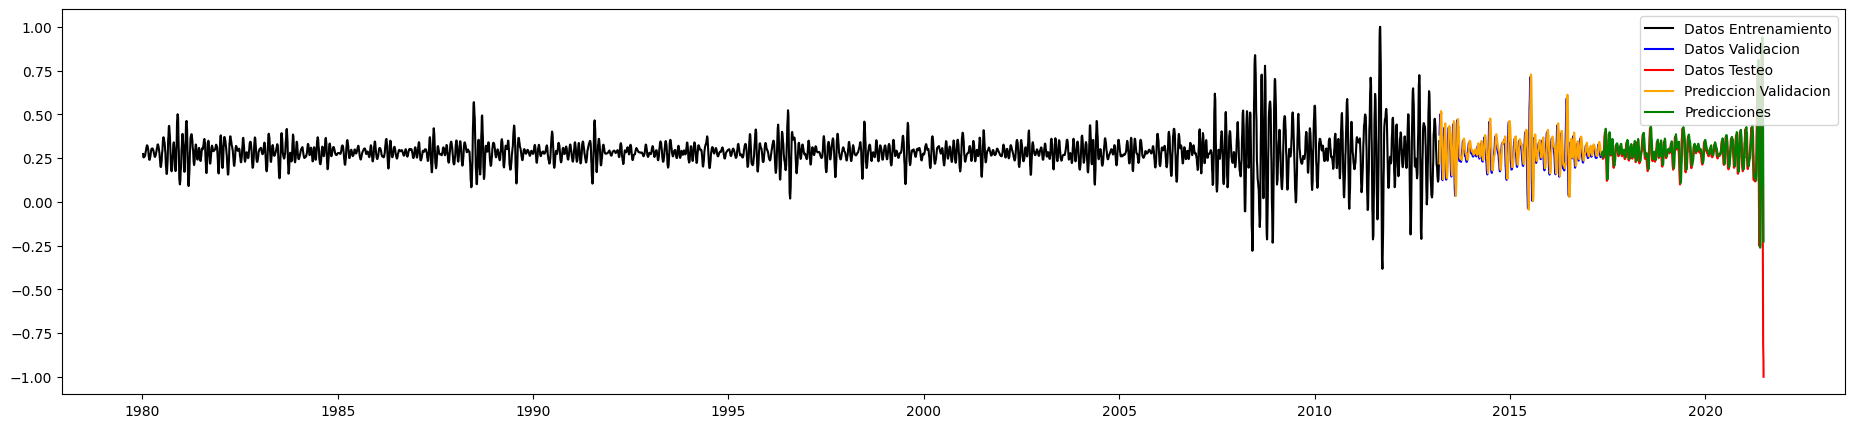

In [62]:
fig, ax = plt.subplots(figsize=(23, 5))
ax.plot(datos_entrenamiento_c3.index,datos_entrenamiento_c3.Precio_Cierre,color='black',label = 'Datos Entrenamiento')
ax.plot(datos_validacion_c3.index,datos_validacion_c3.Precio_Cierre,color='blue',label = 'Datos Validacion')
ax.plot(datos_testeo_c3.index,datos_testeo_c3.Precio_Cierre,color='red',label = 'Datos Testeo')
ax.plot(datos_validacion_c3.index,prediccion_validacion_c3,color='orange',label = 'Prediccion Validacion')
ax.plot(datos_testeo_c3.index,prediccion_testeo_c3 ,color='Green',label = 'Predicciones')
ax.legend(loc = 'upper right')
plt.show()

In [63]:
score = np.sqrt(mean_squared_error(prediccion_validacion_c3,datos_validacion_c3.Precio_Cierre))
print(score)

0.09009993


In [64]:
prediccion_validacion_c3 = componente_3_scaler.inverse_transform(prediccion_validacion_c3)
prediccion_testeo_c3 = componente_3_scaler.inverse_transform(prediccion_testeo_c3 )

# Modelamos Componente 4

In [11]:
componente_4_sup , componente_4_scaler = a_supervisado(componente_4)

In [12]:
datos_entrenamiento_c4, datos_validacion_c4, datos_testeo_c4, X_train, y_train, X_val, y_val, X_test, y_test = division_datos(componente_4_sup)

(12118, 1, 7) (12118,) (1514, 1, 7) (1514,) (1516, 1, 7) (1516,)


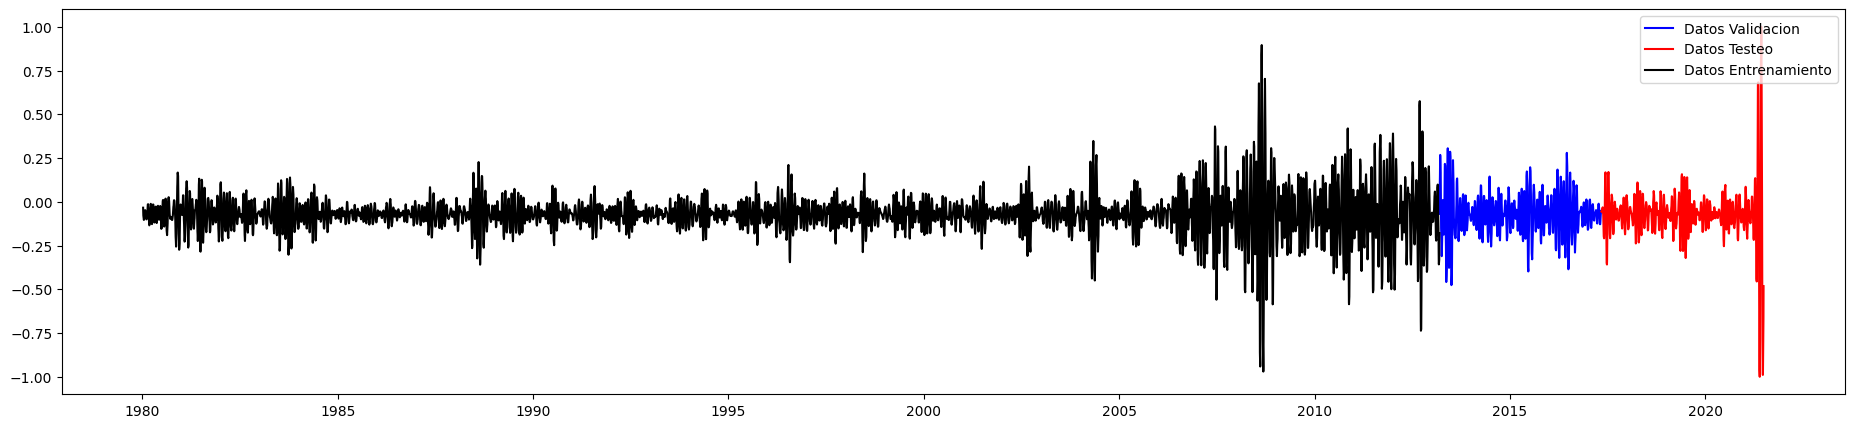

In [36]:
fig, ax = plt.subplots(figsize=(23, 5))
ax.plot(datos_validacion_c4.index,datos_validacion_c4.Precio_Cierre,color='blue',label = 'Datos Validacion')
ax.plot(datos_testeo_c4.index,datos_testeo_c4.Precio_Cierre,color='red',label = 'Datos Testeo')
ax.plot(datos_entrenamiento_c4.index,datos_entrenamiento_c4.Precio_Cierre,color='black',label = 'Datos Entrenamiento')
ax.legend(loc = 'upper right')
plt.show()

In [ ]:
# Crear un estudio Optuna
study = optuna.create_study(direction='minimize')

# Ejecutar la optimización de hiperparámetros
study.optimize(objective, n_trials=100)

# Obtener los mejores hiperparámetros
best_params = study.best_params
print("Mejores hiperparámetros:", best_params)

[I 2024-06-20 21:01:13,388] A new study created in memory with name: no-name-c87b2480-83ce-49fc-88d3-7f741ff82970


48/48 [==============================] - 2s 4ms/step


[I 2024-06-20 21:01:53,837] Trial 0 finished with value: 0.01735716313123703 and parameters: {'units': 59, 'n_layers': 2, 'units_0': 29, 'units_1': 9, 'learning_rate': 0.027462867994284122}. Best is trial 0 with value: 0.01735716313123703.


48/48 [==============================] - 1s 3ms/step


[I 2024-06-20 21:02:37,677] Trial 1 finished with value: 0.017107760533690453 and parameters: {'units': 60, 'n_layers': 1, 'units_0': 14, 'learning_rate': 0.0623631317810211}. Best is trial 1 with value: 0.017107760533690453.


48/48 [==============================] - 2s 3ms/step


[I 2024-06-20 21:03:22,065] Trial 2 finished with value: 0.01640774868428707 and parameters: {'units': 32, 'n_layers': 2, 'units_0': 23, 'units_1': 18, 'learning_rate': 0.03304405754205117}. Best is trial 2 with value: 0.01640774868428707.


48/48 [==============================] - 2s 4ms/step


[I 2024-06-20 21:04:10,744] Trial 3 finished with value: 0.03435902297496796 and parameters: {'units': 11, 'n_layers': 2, 'units_0': 32, 'units_1': 51, 'learning_rate': 0.08172248691810559}. Best is trial 2 with value: 0.01640774868428707.


48/48 [==============================] - 1s 4ms/step


[I 2024-06-20 21:04:43,387] Trial 4 finished with value: 0.010238940827548504 and parameters: {'units': 69, 'n_layers': 1, 'units_0': 30, 'learning_rate': 0.01657861329965426}. Best is trial 4 with value: 0.010238940827548504.


48/48 [==============================] - 2s 3ms/step


[I 2024-06-20 21:05:24,377] Trial 5 finished with value: 0.02144050784409046 and parameters: {'units': 66, 'n_layers': 2, 'units_0': 20, 'units_1': 53, 'learning_rate': 0.0277236287153263}. Best is trial 4 with value: 0.010238940827548504.


48/48 [==============================] - 2s 3ms/step


[I 2024-06-20 21:06:06,976] Trial 6 finished with value: 0.014309650287032127 and parameters: {'units': 69, 'n_layers': 2, 'units_0': 9, 'units_1': 55, 'learning_rate': 0.0066594013532619845}. Best is trial 4 with value: 0.010238940827548504.


48/48 [==============================] - 1s 3ms/step


[I 2024-06-20 21:06:47,169] Trial 7 finished with value: 0.0152335399761796 and parameters: {'units': 17, 'n_layers': 2, 'units_0': 68, 'units_1': 37, 'learning_rate': 0.052385585742072804}. Best is trial 4 with value: 0.010238940827548504.


48/48 [==============================] - 1s 3ms/step


[I 2024-06-20 21:07:33,554] Trial 8 finished with value: 0.012151267379522324 and parameters: {'units': 67, 'n_layers': 1, 'units_0': 62, 'learning_rate': 0.0018911922282260846}. Best is trial 4 with value: 0.010238940827548504.


48/48 [==============================] - 2s 4ms/step


[I 2024-06-20 21:08:21,306] Trial 9 finished with value: 0.011242756620049477 and parameters: {'units': 58, 'n_layers': 1, 'units_0': 61, 'learning_rate': 0.019354328491309584}. Best is trial 4 with value: 0.010238940827548504.


48/48 [==============================] - 1s 3ms/step


[I 2024-06-20 21:08:53,450] Trial 10 finished with value: 0.018541384488344193 and parameters: {'units': 41, 'n_layers': 1, 'units_0': 45, 'learning_rate': 0.08132289098924148}. Best is trial 4 with value: 0.010238940827548504.


48/48 [==============================] - 1s 3ms/step


[I 2024-06-20 21:09:40,272] Trial 11 finished with value: 0.011937128379940987 and parameters: {'units': 49, 'n_layers': 1, 'units_0': 47, 'learning_rate': 0.016498951162820397}. Best is trial 4 with value: 0.010238940827548504.


48/48 [==============================] - 1s 2ms/step


[I 2024-06-20 21:10:26,927] Trial 12 finished with value: 0.012345325201749802 and parameters: {'units': 52, 'n_layers': 1, 'units_0': 55, 'learning_rate': 0.042214268274368895}. Best is trial 4 with value: 0.010238940827548504.


48/48 [==============================] - 1s 4ms/step


[I 2024-06-20 21:10:59,061] Trial 13 finished with value: 0.009477627463638783 and parameters: {'units': 53, 'n_layers': 1, 'units_0': 40, 'learning_rate': 0.017766619199205382}. Best is trial 13 with value: 0.009477627463638783.


48/48 [==============================] - 2s 4ms/step


[I 2024-06-20 21:11:32,124] Trial 14 finished with value: 0.013735885731875896 and parameters: {'units': 41, 'n_layers': 1, 'units_0': 41, 'learning_rate': 0.0988430594980089}. Best is trial 13 with value: 0.009477627463638783.


48/48 [==============================] - 2s 4ms/step


[I 2024-06-20 21:12:05,273] Trial 15 finished with value: 0.012503902427852154 and parameters: {'units': 31, 'n_layers': 1, 'units_0': 34, 'learning_rate': 0.010792536120606001}. Best is trial 13 with value: 0.009477627463638783.


48/48 [==============================] - 1s 3ms/step


[I 2024-06-20 21:12:35,819] Trial 16 finished with value: 0.0648561492562294 and parameters: {'units': 51, 'n_layers': 1, 'units_0': 49, 'learning_rate': 0.043290925697891246}. Best is trial 13 with value: 0.009477627463638783.


48/48 [==============================] - 1s 2ms/step


[I 2024-06-20 21:13:22,381] Trial 17 finished with value: 0.013393769972026348 and parameters: {'units': 48, 'n_layers': 1, 'units_0': 38, 'learning_rate': 0.06206037229455775}. Best is trial 13 with value: 0.009477627463638783.


48/48 [==============================] - 1s 2ms/step


[I 2024-06-20 21:13:52,380] Trial 18 finished with value: 0.012637817300856113 and parameters: {'units': 62, 'n_layers': 1, 'units_0': 24, 'learning_rate': 0.022737577755430775}. Best is trial 13 with value: 0.009477627463638783.


48/48 [==============================] - 1s 4ms/step


[I 2024-06-20 21:14:45,801] Trial 19 finished with value: 0.012726002372801304 and parameters: {'units': 32, 'n_layers': 1, 'units_0': 39, 'learning_rate': 0.03731352255595344}. Best is trial 13 with value: 0.009477627463638783.


48/48 [==============================] - 1s 4ms/step


[I 2024-06-20 21:15:32,364] Trial 20 finished with value: 0.011253300122916698 and parameters: {'units': 55, 'n_layers': 1, 'units_0': 29, 'learning_rate': 0.0014604146294665676}. Best is trial 13 with value: 0.009477627463638783.


48/48 [==============================] - 2s 4ms/step


[I 2024-06-20 21:16:10,018] Trial 21 finished with value: 0.010774240829050541 and parameters: {'units': 58, 'n_layers': 1, 'units_0': 56, 'learning_rate': 0.015951328848917624}. Best is trial 13 with value: 0.009477627463638783.


48/48 [==============================] - 1s 3ms/step


[I 2024-06-20 21:16:56,895] Trial 22 finished with value: 0.011971901170909405 and parameters: {'units': 70, 'n_layers': 1, 'units_0': 53, 'learning_rate': 0.01103793236207298}. Best is trial 13 with value: 0.009477627463638783.


48/48 [==============================] - 1s 3ms/step


[I 2024-06-20 21:17:31,424] Trial 23 finished with value: 0.010196292772889137 and parameters: {'units': 45, 'n_layers': 1, 'units_0': 70, 'learning_rate': 0.01570837029389569}. Best is trial 13 with value: 0.009477627463638783.


48/48 [==============================] - 2s 5ms/step


[I 2024-06-20 21:18:04,987] Trial 24 finished with value: 0.013010038062930107 and parameters: {'units': 46, 'n_layers': 1, 'units_0': 67, 'learning_rate': 0.026843951173705513}. Best is trial 13 with value: 0.009477627463638783.


48/48 [==============================] - 1s 3ms/step


[I 2024-06-20 21:18:51,823] Trial 25 finished with value: 0.025728067383170128 and parameters: {'units': 37, 'n_layers': 1, 'units_0': 15, 'learning_rate': 0.03510138022082675}. Best is trial 13 with value: 0.009477627463638783.


48/48 [==============================] - 1s 2ms/step


[I 2024-06-20 21:19:22,260] Trial 26 finished with value: 0.011593407019972801 and parameters: {'units': 43, 'n_layers': 1, 'units_0': 7, 'learning_rate': 0.011324112103676058}. Best is trial 13 with value: 0.009477627463638783.


48/48 [==============================] - 1s 4ms/step


[I 2024-06-20 21:19:53,635] Trial 27 finished with value: 0.021826282143592834 and parameters: {'units': 22, 'n_layers': 1, 'units_0': 70, 'learning_rate': 0.05061307468562292}. Best is trial 13 with value: 0.009477627463638783.


48/48 [==============================] - 2s 4ms/step


[I 2024-06-20 21:20:29,253] Trial 28 finished with value: 0.011721232905983925 and parameters: {'units': 64, 'n_layers': 1, 'units_0': 62, 'learning_rate': 0.022520954116174854}. Best is trial 13 with value: 0.009477627463638783.


48/48 [==============================] - 1s 3ms/step


[I 2024-06-20 21:21:18,389] Trial 29 finished with value: 0.015473464503884315 and parameters: {'units': 36, 'n_layers': 2, 'units_0': 26, 'units_1': 70, 'learning_rate': 0.028462858237604666}. Best is trial 13 with value: 0.009477627463638783.


48/48 [==============================] - 1s 3ms/step


[I 2024-06-20 21:21:48,908] Trial 30 finished with value: 0.011108603328466415 and parameters: {'units': 53, 'n_layers': 1, 'units_0': 33, 'learning_rate': 0.0009756004874048284}. Best is trial 13 with value: 0.009477627463638783.


48/48 [==============================] - 1s 3ms/step


[I 2024-06-20 21:22:20,251] Trial 31 finished with value: 0.011929364874958992 and parameters: {'units': 57, 'n_layers': 1, 'units_0': 54, 'learning_rate': 0.015073445628807556}. Best is trial 13 with value: 0.009477627463638783.


48/48 [==============================] - 2s 4ms/step


[I 2024-06-20 21:23:08,688] Trial 32 finished with value: 0.011968330480158329 and parameters: {'units': 60, 'n_layers': 1, 'units_0': 43, 'learning_rate': 0.018510552274631317}. Best is trial 13 with value: 0.009477627463638783.


48/48 [==============================] - 1s 3ms/step


[I 2024-06-20 21:23:39,528] Trial 33 finished with value: 0.01110026054084301 and parameters: {'units': 63, 'n_layers': 1, 'units_0': 59, 'learning_rate': 0.007054383145599972}. Best is trial 13 with value: 0.009477627463638783.


48/48 [==============================] - 1s 3ms/step


[I 2024-06-20 21:24:26,088] Trial 34 finished with value: 0.014222165569663048 and parameters: {'units': 45, 'n_layers': 1, 'units_0': 51, 'learning_rate': 0.030949457567967197}. Best is trial 13 with value: 0.009477627463638783.


48/48 [==============================] - 1s 4ms/step


[I 2024-06-20 21:25:12,959] Trial 35 finished with value: 0.012210993096232414 and parameters: {'units': 55, 'n_layers': 1, 'units_0': 57, 'learning_rate': 0.02264820981865813}. Best is trial 13 with value: 0.009477627463638783.


48/48 [==============================] - 2s 4ms/step


[I 2024-06-20 21:26:03,060] Trial 36 finished with value: 0.014649123884737492 and parameters: {'units': 60, 'n_layers': 2, 'units_0': 65, 'units_1': 27, 'learning_rate': 0.007501704998660791}. Best is trial 13 with value: 0.009477627463638783.


48/48 [==============================] - 1s 3ms/step


[I 2024-06-20 21:26:33,391] Trial 37 finished with value: 0.013453979976475239 and parameters: {'units': 64, 'n_layers': 1, 'units_0': 19, 'learning_rate': 0.03981880630132405}. Best is trial 13 with value: 0.009477627463638783.


48/48 [==============================] - 1s 3ms/step


[I 2024-06-20 21:27:21,783] Trial 38 finished with value: 0.015807542949914932 and parameters: {'units': 66, 'n_layers': 2, 'units_0': 36, 'units_1': 66, 'learning_rate': 0.013779987045004476}. Best is trial 13 with value: 0.009477627463638783.


48/48 [==============================] - 2s 4ms/step


[I 2024-06-20 21:28:10,390] Trial 39 finished with value: 0.018922362476587296 and parameters: {'units': 56, 'n_layers': 1, 'units_0': 30, 'learning_rate': 0.06272190286935796}. Best is trial 13 with value: 0.009477627463638783.


48/48 [==============================] - 1s 3ms/step


[I 2024-06-20 21:28:59,443] Trial 40 finished with value: 0.015478045679628849 and parameters: {'units': 49, 'n_layers': 2, 'units_0': 26, 'units_1': 37, 'learning_rate': 0.024528094554296588}. Best is trial 13 with value: 0.009477627463638783.


48/48 [==============================] - 2s 4ms/step


[I 2024-06-20 21:29:49,282] Trial 41 finished with value: 0.011219033040106297 and parameters: {'units': 68, 'n_layers': 1, 'units_0': 58, 'learning_rate': 0.00806159411178508}. Best is trial 13 with value: 0.009477627463638783.


48/48 [==============================] - 2s 5ms/step


[I 2024-06-20 21:30:30,346] Trial 42 finished with value: 0.010645399801433086 and parameters: {'units': 63, 'n_layers': 1, 'units_0': 63, 'learning_rate': 0.003958390787485718}. Best is trial 13 with value: 0.009477627463638783.


48/48 [==============================] - 1s 4ms/step


[I 2024-06-20 21:31:17,827] Trial 43 finished with value: 0.012973024509847164 and parameters: {'units': 61, 'n_layers': 1, 'units_0': 65, 'learning_rate': 0.017630648629389196}. Best is trial 13 with value: 0.009477627463638783.


48/48 [==============================] - 1s 3ms/step


[I 2024-06-20 21:31:53,559] Trial 44 finished with value: 0.012209730222821236 and parameters: {'units': 70, 'n_layers': 1, 'units_0': 69, 'learning_rate': 0.0035364921207623624}. Best is trial 13 with value: 0.009477627463638783.


48/48 [==============================] - 1s 4ms/step


[I 2024-06-20 21:32:29,796] Trial 45 finished with value: 0.016318894922733307 and parameters: {'units': 58, 'n_layers': 1, 'units_0': 64, 'learning_rate': 0.03101204376142952}. Best is trial 13 with value: 0.009477627463638783.


48/48 [==============================] - 1s 4ms/step


[I 2024-06-20 21:33:16,484] Trial 46 finished with value: 0.013215371407568455 and parameters: {'units': 65, 'n_layers': 1, 'units_0': 61, 'learning_rate': 0.01925385322142161}. Best is trial 13 with value: 0.009477627463638783.


48/48 [==============================] - 1s 3ms/step


[I 2024-06-20 21:34:03,543] Trial 47 finished with value: 0.01022559404373169 and parameters: {'units': 53, 'n_layers': 1, 'units_0': 47, 'learning_rate': 0.004745479203967652}. Best is trial 13 with value: 0.009477627463638783.


48/48 [==============================] - 1s 2ms/step


[I 2024-06-20 21:34:51,127] Trial 48 finished with value: 0.011206033639609814 and parameters: {'units': 52, 'n_layers': 1, 'units_0': 45, 'learning_rate': 0.004830043610645066}. Best is trial 13 with value: 0.009477627463638783.


48/48 [==============================] - 1s 3ms/step


[I 2024-06-20 21:35:21,523] Trial 49 finished with value: 0.010104401968419552 and parameters: {'units': 46, 'n_layers': 1, 'units_0': 48, 'learning_rate': 0.009471425468251096}. Best is trial 13 with value: 0.009477627463638783.


48/48 [==============================] - 1s 3ms/step


[I 2024-06-20 21:36:07,620] Trial 50 finished with value: 0.009512778371572495 and parameters: {'units': 38, 'n_layers': 1, 'units_0': 49, 'learning_rate': 0.011086669856035038}. Best is trial 13 with value: 0.009477627463638783.


48/48 [==============================] - 1s 4ms/step


[I 2024-06-20 21:36:54,668] Trial 51 finished with value: 0.012621785514056683 and parameters: {'units': 38, 'n_layers': 1, 'units_0': 48, 'learning_rate': 0.011702146306038705}. Best is trial 13 with value: 0.009477627463638783.


48/48 [==============================] - 1s 3ms/step


[I 2024-06-20 21:37:42,162] Trial 52 finished with value: 0.011288667097687721 and parameters: {'units': 34, 'n_layers': 1, 'units_0': 41, 'learning_rate': 0.008527259965975415}. Best is trial 13 with value: 0.009477627463638783.


48/48 [==============================] - 1s 2ms/step


[I 2024-06-20 21:38:28,340] Trial 53 finished with value: 0.01116254273802042 and parameters: {'units': 43, 'n_layers': 1, 'units_0': 50, 'learning_rate': 0.0007247236124613716}. Best is trial 13 with value: 0.009477627463638783.


48/48 [==============================] - 1s 3ms/step


[I 2024-06-20 21:39:16,020] Trial 54 finished with value: 0.009773730300366879 and parameters: {'units': 30, 'n_layers': 1, 'units_0': 46, 'learning_rate': 0.014376406461318846}. Best is trial 13 with value: 0.009477627463638783.


48/48 [==============================] - 1s 3ms/step


[I 2024-06-20 21:40:02,352] Trial 55 finished with value: 0.011683243326842785 and parameters: {'units': 27, 'n_layers': 1, 'units_0': 45, 'learning_rate': 0.056420546891493104}. Best is trial 13 with value: 0.009477627463638783.


48/48 [==============================] - 1s 3ms/step


[I 2024-06-20 21:40:32,080] Trial 56 finished with value: 0.06237804889678955 and parameters: {'units': 30, 'n_layers': 1, 'units_0': 52, 'learning_rate': 0.08196997664348385}. Best is trial 13 with value: 0.009477627463638783.


48/48 [==============================] - 1s 2ms/step


[I 2024-06-20 21:41:01,480] Trial 57 finished with value: 0.010750277899205685 and parameters: {'units': 26, 'n_layers': 1, 'units_0': 47, 'learning_rate': 0.0138145574460109}. Best is trial 13 with value: 0.009477627463638783.


48/48 [==============================] - 1s 2ms/step


[I 2024-06-20 21:41:30,595] Trial 58 finished with value: 0.011249077506363392 and parameters: {'units': 39, 'n_layers': 1, 'units_0': 38, 'learning_rate': 0.02117695104079076}. Best is trial 13 with value: 0.009477627463638783.


48/48 [==============================] - 1s 3ms/step


[I 2024-06-20 21:42:01,596] Trial 59 finished with value: 0.012502696365118027 and parameters: {'units': 46, 'n_layers': 1, 'units_0': 42, 'learning_rate': 0.04656528404746714}. Best is trial 13 with value: 0.009477627463638783.


48/48 [==============================] - 1s 2ms/step


[I 2024-06-20 21:42:47,876] Trial 60 finished with value: 0.010125232860445976 and parameters: {'units': 41, 'n_layers': 1, 'units_0': 35, 'learning_rate': 0.02544849333267577}. Best is trial 13 with value: 0.009477627463638783.


48/48 [==============================] - 1s 2ms/step


[I 2024-06-20 21:43:17,620] Trial 61 finished with value: 0.012277919799089432 and parameters: {'units': 41, 'n_layers': 1, 'units_0': 35, 'learning_rate': 0.01069978330502317}. Best is trial 13 with value: 0.009477627463638783.


48/48 [==============================] - 1s 3ms/step


[I 2024-06-20 21:44:05,297] Trial 62 finished with value: 0.015090332366526127 and parameters: {'units': 43, 'n_layers': 1, 'units_0': 44, 'learning_rate': 0.02596571159219835}. Best is trial 13 with value: 0.009477627463638783.


48/48 [==============================] - 1s 3ms/step


[I 2024-06-20 21:44:51,534] Trial 63 finished with value: 0.01302517019212246 and parameters: {'units': 49, 'n_layers': 1, 'units_0': 40, 'learning_rate': 0.016205231434233174}. Best is trial 13 with value: 0.009477627463638783.


48/48 [==============================] - 1s 3ms/step


[I 2024-06-20 21:45:20,354] Trial 64 finished with value: 0.010002817958593369 and parameters: {'units': 35, 'n_layers': 1, 'units_0': 37, 'learning_rate': 0.011830615888755933}. Best is trial 13 with value: 0.009477627463638783.


48/48 [==============================] - 1s 3ms/step


[I 2024-06-20 21:45:48,839] Trial 65 finished with value: 0.011716115288436413 and parameters: {'units': 34, 'n_layers': 1, 'units_0': 37, 'learning_rate': 0.019825926519305113}. Best is trial 13 with value: 0.009477627463638783.


48/48 [==============================] - 1s 3ms/step


[I 2024-06-20 21:46:35,113] Trial 66 finished with value: 0.011831180192530155 and parameters: {'units': 35, 'n_layers': 1, 'units_0': 31, 'learning_rate': 0.013269875486329002}. Best is trial 13 with value: 0.009477627463638783.


48/48 [==============================] - 1s 3ms/step


[I 2024-06-20 21:47:05,596] Trial 67 finished with value: 0.011480653658509254 and parameters: {'units': 29, 'n_layers': 1, 'units_0': 34, 'learning_rate': 0.028546119129019304}. Best is trial 13 with value: 0.009477627463638783.


48/48 [==============================] - 1s 2ms/step


[I 2024-06-20 21:47:34,052] Trial 68 finished with value: 0.01126057468354702 and parameters: {'units': 22, 'n_layers': 1, 'units_0': 40, 'learning_rate': 0.03364805432591585}. Best is trial 13 with value: 0.009477627463638783.


48/48 [==============================] - 1s 4ms/step


[I 2024-06-20 21:48:19,053] Trial 69 finished with value: 0.011211727745831013 and parameters: {'units': 40, 'n_layers': 1, 'units_0': 32, 'learning_rate': 0.010728089045338856}. Best is trial 13 with value: 0.009477627463638783.


48/48 [==============================] - 2s 4ms/step


[I 2024-06-20 21:49:06,439] Trial 70 finished with value: 0.011208666488528252 and parameters: {'units': 33, 'n_layers': 1, 'units_0': 27, 'learning_rate': 0.016670806504248303}. Best is trial 13 with value: 0.009477627463638783.


48/48 [==============================] - 1s 3ms/step


[I 2024-06-20 21:49:43,056] Trial 71 finished with value: 0.01200847327709198 and parameters: {'units': 45, 'n_layers': 1, 'units_0': 47, 'learning_rate': 0.005506909087999613}. Best is trial 13 with value: 0.009477627463638783.


48/48 [==============================] - 1s 3ms/step


[I 2024-06-20 21:50:16,482] Trial 72 finished with value: 0.010605225339531898 and parameters: {'units': 37, 'n_layers': 1, 'units_0': 42, 'learning_rate': 0.00872345874108821}. Best is trial 13 with value: 0.009477627463638783.


48/48 [==============================] - 2s 4ms/step


[I 2024-06-20 21:50:52,187] Trial 73 finished with value: 0.012417883612215519 and parameters: {'units': 50, 'n_layers': 1, 'units_0': 49, 'learning_rate': 0.00012418937941141572}. Best is trial 13 with value: 0.009477627463638783.


48/48 [==============================] - 1s 3ms/step


[I 2024-06-20 21:51:38,460] Trial 74 finished with value: 0.012681913562119007 and parameters: {'units': 53, 'n_layers': 1, 'units_0': 38, 'learning_rate': 0.02319733541772578}. Best is trial 13 with value: 0.009477627463638783.


48/48 [==============================] - 1s 2ms/step


[I 2024-06-20 21:52:24,662] Trial 75 finished with value: 0.012930609285831451 and parameters: {'units': 12, 'n_layers': 1, 'units_0': 46, 'learning_rate': 0.014841196825028742}. Best is trial 13 with value: 0.009477627463638783.


48/48 [==============================] - 1s 3ms/step


[I 2024-06-20 21:53:12,191] Trial 76 finished with value: 0.01137265283614397 and parameters: {'units': 47, 'n_layers': 1, 'units_0': 54, 'learning_rate': 0.005841840897800526}. Best is trial 13 with value: 0.009477627463638783.


48/48 [==============================] - 1s 3ms/step


[I 2024-06-20 21:53:58,534] Trial 77 finished with value: 0.011182603426277637 and parameters: {'units': 44, 'n_layers': 1, 'units_0': 43, 'learning_rate': 0.010318203127806215}. Best is trial 13 with value: 0.009477627463638783.


48/48 [==============================] - 1s 5ms/step


[I 2024-06-20 21:54:45,441] Trial 78 finished with value: 0.012051429599523544 and parameters: {'units': 41, 'n_layers': 1, 'units_0': 51, 'learning_rate': 0.02073208235015827}. Best is trial 13 with value: 0.009477627463638783.


48/48 [==============================] - 1s 3ms/step


[I 2024-06-20 21:55:34,262] Trial 79 finished with value: 0.010999927297234535 and parameters: {'units': 47, 'n_layers': 1, 'units_0': 49, 'learning_rate': 0.0027560339718995953}. Best is trial 13 with value: 0.009477627463638783.


48/48 [==============================] - 1s 3ms/step


[I 2024-06-20 21:56:20,488] Trial 80 finished with value: 0.010875570587813854 and parameters: {'units': 32, 'n_layers': 1, 'units_0': 37, 'learning_rate': 0.013155654788455979}. Best is trial 13 with value: 0.009477627463638783.


48/48 [==============================] - 1s 4ms/step


[I 2024-06-20 21:57:07,201] Trial 81 finished with value: 0.011792798526585102 and parameters: {'units': 39, 'n_layers': 1, 'units_0': 29, 'learning_rate': 0.017093357903734063}. Best is trial 13 with value: 0.009477627463638783.


48/48 [==============================] - 1s 2ms/step


[I 2024-06-20 21:57:38,699] Trial 82 finished with value: 0.01343920361250639 and parameters: {'units': 36, 'n_layers': 1, 'units_0': 34, 'learning_rate': 0.024614487015627563}. Best is trial 13 with value: 0.009477627463638783.


48/48 [==============================] - 1s 2ms/step


[I 2024-06-20 21:58:08,411] Trial 83 finished with value: 0.011126215569674969 and parameters: {'units': 42, 'n_layers': 1, 'units_0': 22, 'learning_rate': 0.008491824988629883}. Best is trial 13 with value: 0.009477627463638783.


48/48 [==============================] - 1s 3ms/step


[I 2024-06-20 21:58:56,501] Trial 84 finished with value: 0.011269177310168743 and parameters: {'units': 55, 'n_layers': 1, 'units_0': 36, 'learning_rate': 0.0183241669383015}. Best is trial 13 with value: 0.009477627463638783.


48/48 [==============================] - 2s 4ms/step


[I 2024-06-20 21:59:35,093] Trial 85 finished with value: 0.013324109837412834 and parameters: {'units': 51, 'n_layers': 2, 'units_0': 39, 'units_1': 26, 'learning_rate': 0.006070367218845036}. Best is trial 13 with value: 0.009477627463638783.


48/48 [==============================] - 2s 4ms/step


[I 2024-06-20 22:00:06,866] Trial 86 finished with value: 0.01479425374418497 and parameters: {'units': 26, 'n_layers': 1, 'units_0': 44, 'learning_rate': 0.07104658248938978}. Best is trial 13 with value: 0.009477627463638783.


48/48 [==============================] - 1s 3ms/step


[I 2024-06-20 22:00:53,842] Trial 87 finished with value: 0.010730531997978687 and parameters: {'units': 29, 'n_layers': 1, 'units_0': 15, 'learning_rate': 0.012898696694089636}. Best is trial 13 with value: 0.009477627463638783.


48/48 [==============================] - 1s 3ms/step


[I 2024-06-20 22:01:22,896] Trial 88 finished with value: 0.010090352967381477 and parameters: {'units': 37, 'n_layers': 1, 'units_0': 28, 'learning_rate': 0.014945704416736837}. Best is trial 13 with value: 0.009477627463638783.


48/48 [==============================] - 1s 3ms/step


[I 2024-06-20 22:02:09,441] Trial 89 finished with value: 0.011524765752255917 and parameters: {'units': 37, 'n_layers': 1, 'units_0': 18, 'learning_rate': 0.003642747661242492}. Best is trial 13 with value: 0.009477627463638783.


48/48 [==============================] - 1s 2ms/step


[I 2024-06-20 22:02:56,779] Trial 90 finished with value: 0.012354024685919285 and parameters: {'units': 39, 'n_layers': 1, 'units_0': 24, 'learning_rate': 0.015118308556118475}. Best is trial 13 with value: 0.009477627463638783.


48/48 [==============================] - 1s 2ms/step


[I 2024-06-20 22:03:42,996] Trial 91 finished with value: 0.011353302747011185 and parameters: {'units': 31, 'n_layers': 1, 'units_0': 27, 'learning_rate': 0.020932375363261025}. Best is trial 13 with value: 0.009477627463638783.


48/48 [==============================] - 1s 2ms/step


[I 2024-06-20 22:04:11,467] Trial 92 finished with value: 0.01277525257319212 and parameters: {'units': 36, 'n_layers': 1, 'units_0': 32, 'learning_rate': 0.009221808370093721}. Best is trial 13 with value: 0.009477627463638783.


48/48 [==============================] - 1s 3ms/step


[I 2024-06-20 22:04:40,032] Trial 93 finished with value: 0.011837799102067947 and parameters: {'units': 42, 'n_layers': 1, 'units_0': 29, 'learning_rate': 0.012009735493286603}. Best is trial 13 with value: 0.009477627463638783.


48/48 [==============================] - 1s 4ms/step


[I 2024-06-20 22:05:09,360] Trial 94 finished with value: 0.012210101820528507 and parameters: {'units': 45, 'n_layers': 1, 'units_0': 30, 'learning_rate': 0.017144695602329996}. Best is trial 13 with value: 0.009477627463638783.


48/48 [==============================] - 1s 3ms/step


[I 2024-06-20 22:05:38,775] Trial 95 finished with value: 0.011961312033236027 and parameters: {'units': 48, 'n_layers': 1, 'units_0': 56, 'learning_rate': 0.02957637264920345}. Best is trial 13 with value: 0.009477627463638783.


48/48 [==============================] - 1s 3ms/step


[I 2024-06-20 22:06:08,436] Trial 96 finished with value: 0.011614535935223103 and parameters: {'units': 35, 'n_layers': 1, 'units_0': 67, 'learning_rate': 0.025981367748063828}. Best is trial 13 with value: 0.009477627463638783.


48/48 [==============================] - 1s 3ms/step


[I 2024-06-20 22:06:37,589] Trial 97 finished with value: 0.009986680932343006 and parameters: {'units': 38, 'n_layers': 1, 'units_0': 33, 'learning_rate': 0.007445429982087272}. Best is trial 13 with value: 0.009477627463638783.


48/48 [==============================] - 1s 3ms/step


[I 2024-06-20 22:07:06,210] Trial 98 finished with value: 0.01418993342667818 and parameters: {'units': 38, 'n_layers': 1, 'units_0': 11, 'learning_rate': 0.09822847287659066}. Best is trial 13 with value: 0.009477627463638783.


48/48 [==============================] - 1s 2ms/step


[I 2024-06-20 22:07:35,609] Trial 99 finished with value: 0.01329233031719923 and parameters: {'units': 40, 'n_layers': 1, 'units_0': 35, 'learning_rate': 0.007850290901797176}. Best is trial 13 with value: 0.009477627463638783.


Mejores hiperparámetros: {'units': 53, 'n_layers': 1, 'units_0': 40, 'learning_rate': 0.017766619199205382}


In [29]:
def modeloRR_c4():
  modelo = Sequential()
  modelo.add(LSTM(units=53, input_shape=(1,7), activation='tanh', return_sequences=True))
  modelo.add(LSTM(units=40,  activation='tanh', return_sequences=False))
  modelo.add(Dense(units=1))
  modelo.compile(optimizer=tf.keras.optimizers.RMSprop( 0.01776), loss='mse')
  return modelo

In [30]:
modelo = modeloRR_c4()
modelo.fit(X_train,y_train,epochs=40,batch_size=7)

Epoch 1/40
1732/1732 [==============================] - 27s 11ms/step - loss: 0.0016
Epoch 2/40
1732/1732 [==============================] - 13s 7ms/step - loss: 8.0375e-04
Epoch 3/40
1732/1732 [==============================] - 10s 6ms/step - loss: 6.4085e-04
Epoch 4/40
1732/1732 [==============================] - 10s 6ms/step - loss: 5.4841e-04
Epoch 5/40
1732/1732 [==============================] - 11s 6ms/step - loss: 5.2125e-04
Epoch 6/40
1732/1732 [==============================] - 9s 5ms/step - loss: 4.8623e-04
Epoch 7/40
1732/1732 [==============================] - 9s 5ms/step - loss: 4.5748e-04
Epoch 8/40
1732/1732 [==============================] - 10s 6ms/step - loss: 4.1671e-04
Epoch 9/40
1732/1732 [==============================] - 9s 5ms/step - loss: 4.1948e-04
Epoch 10/40
1732/1732 [==============================] - 9s 5ms/step - loss: 3.9964e-04
Epoch 11/40
1732/1732 [==============================] - 9s 5ms/step - loss: 4.0045e-04
Epoch 12/40
1732/1732 [===============

In [31]:
prediccion_validacion_c4 = modelo.predict(X_val)
prediccion_testeo_c4 = modelo.predict(X_test)

48/48 [==============================] - 0s 3ms/step


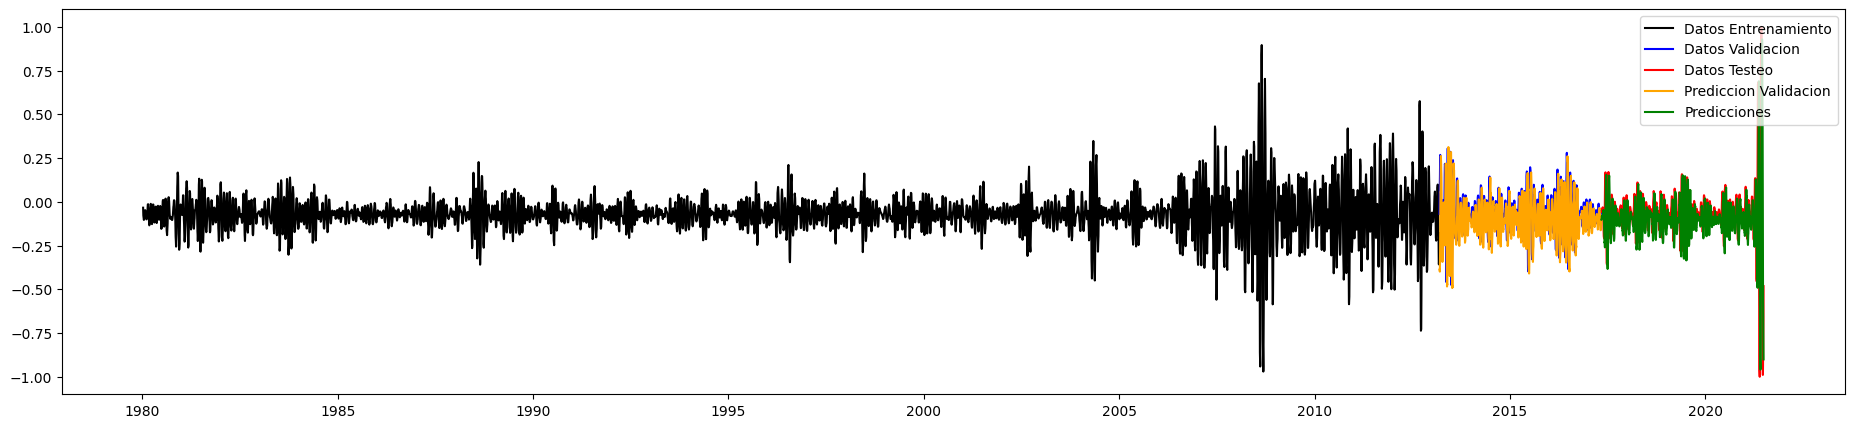

In [32]:
fig, ax = plt.subplots(figsize=(23, 5))
ax.plot(datos_entrenamiento_c4.index,datos_entrenamiento_c4.Precio_Cierre,color='black',label = 'Datos Entrenamiento')
ax.plot(datos_validacion_c4.index,datos_validacion_c4.Precio_Cierre,color='blue',label = 'Datos Validacion')
ax.plot(datos_testeo_c4.index,datos_testeo_c4.Precio_Cierre,color='red',label = 'Datos Testeo')
ax.plot(datos_validacion_c4.index,prediccion_validacion_c4,color='orange',label = 'Prediccion Validacion')
ax.plot(datos_testeo_c4.index,prediccion_testeo_c4 ,color='Green',label = 'Predicciones')
ax.legend(loc = 'upper right')
plt.show()

In [33]:
score = np.sqrt(mean_squared_error(prediccion_validacion_c4,datos_validacion_c4.Precio_Cierre))
print(score)

0.17534187


In [34]:
prediccion_validacion_c4 = componente_4_scaler.inverse_transform(prediccion_validacion_c4)
prediccion_testeo_c4 = componente_4_scaler.inverse_transform(prediccion_testeo_c4 )

# Ensemble

In [35]:
total_datos=len(datos_originales.Precio_Cierre)
porcentaje_entrenamiento, porcentaje_validacion = 0.8,0.1
division_entrenamiento = int(total_datos*porcentaje_entrenamiento)
division_validacion = division_entrenamiento + int(porcentaje_validacion*total_datos)


datos_entrenamiento = datos_originales[:division_entrenamiento]
datos_validacion_originales = datos_originales[division_entrenamiento:division_validacion]
datos_testeo_originales = datos_originales[division_validacion:total_datos]

In [66]:
validacion = prediccion_validacion_c1 + prediccion_validacion_c2 + prediccion_validacion_c3 + prediccion_validacion_c4
recm_validacion = np.sqrt(mean_squared_error(validacion,datos_validacion_originales.Precio_Cierre[1:]))
eam_validacion = mean_absolute_error( validacion,datos_validacion_originales.Precio_Cierre[1:])
EPAM_validacion = mean_absolute_percentage_error( validacion,datos_validacion_originales.Precio_Cierre[1:])


#Imprimir las metricas de validacion del modelo
print ( f'La raiz del error cuadratico medio del modelo es: {recm_validacion} ' )
print ( f'el error absoluto medio del modelo es: {eam_validacion} ' )
print(f"Error porcentual absoluto medio del modelo es: {EPAM_validacion}")

La raiz del error cuadratico medio del modelo es: 12.219876964551368 
el error absoluto medio del modelo es: 9.032152241245338 
Error porcentual absoluto medio del modelo es: 0.020472205729086236


In [67]:
prediccion = prediccion_testeo_c1 + prediccion_testeo_c2 + prediccion_testeo_c3 +prediccion_testeo_c4

In [68]:
recm = np.sqrt(mean_squared_error( prediccion,datos_testeo_originales.Precio_Cierre))
eam = mean_absolute_error( prediccion,datos_testeo_originales.Precio_Cierre)
EPAM = mean_absolute_percentage_error(prediccion,datos_testeo_originales.Precio_Cierre)


#Imprimir las metricas de validacion del modelo
print ( f'La raiz del error cuadratico medio del modelo es: {recm} ' )
print ( f'el error absoluto medio del modelo es: {eam} ' )
print(f"Error porcentual absoluto medio del modelo es: {EPAM}")

La raiz del error cuadratico medio del modelo es: 10.549369677726865 
el error absoluto medio del modelo es: 6.949826162534528 
Error porcentual absoluto medio del modelo es: 0.01634216398868739


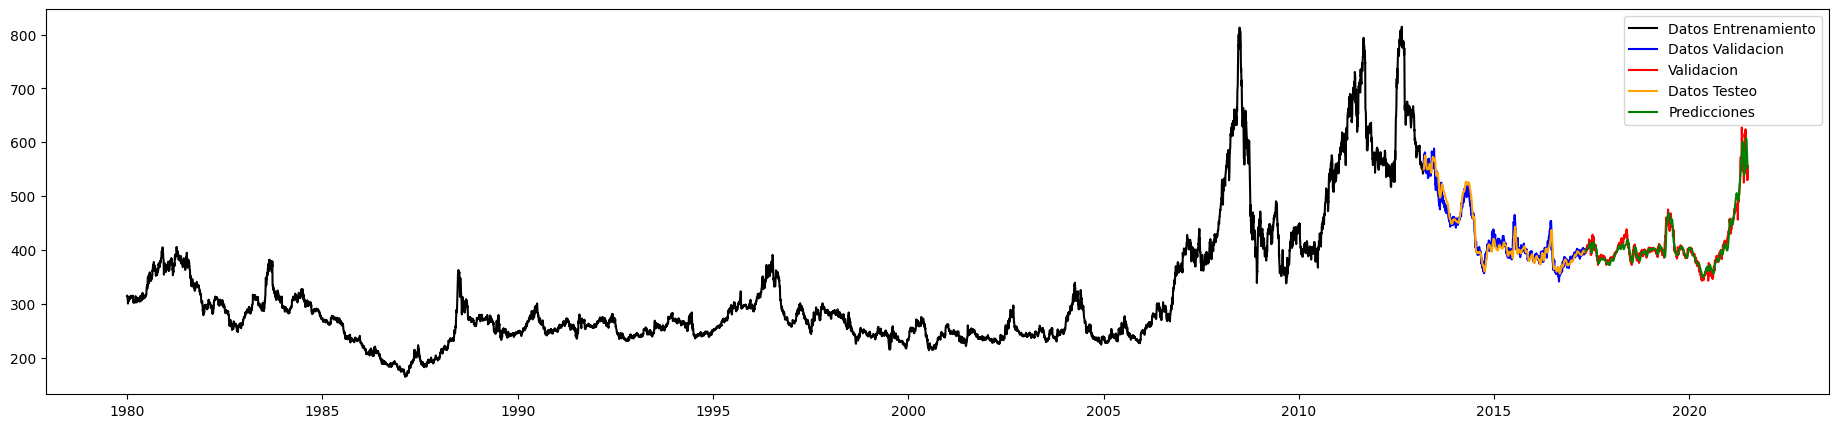

In [69]:
fig, ax = plt.subplots(figsize=(23, 5))
ax.plot(datos_entrenamiento.index,datos_entrenamiento.Precio_Cierre,color='black',label = 'Datos Entrenamiento')
ax.plot(datos_validacion_originales.index,datos_validacion_originales.Precio_Cierre,color='blue',label = 'Datos Validacion')
ax.plot(datos_testeo_originales.index,datos_testeo_originales.Precio_Cierre,color='red',label = 'Validacion')
ax.plot(datos_validacion_originales[1:].index,validacion,color='orange',label = 'Datos Testeo')
ax.plot(datos_testeo_originales.index,prediccion,color='Green',label = 'Predicciones')
ax.legend(loc = 'upper right')
plt.show()

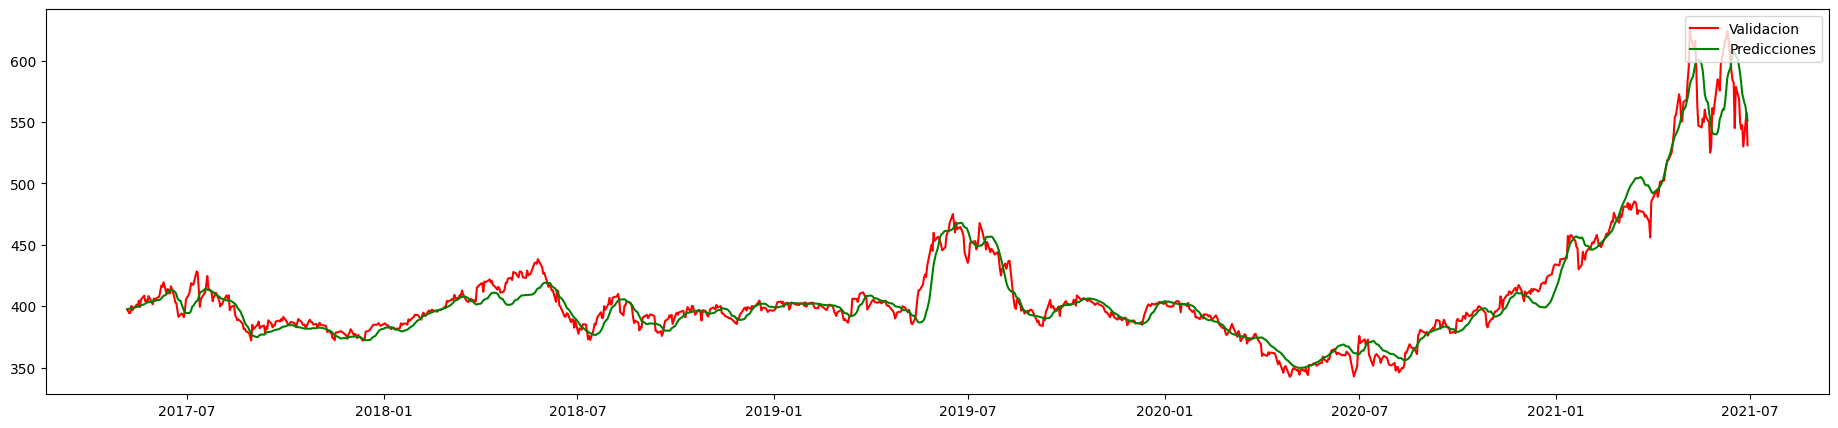

In [70]:
fig, ax = plt.subplots(figsize=(23, 5))
ax.plot(datos_testeo_originales.index,datos_testeo_originales.Precio_Cierre,color='red',label = 'Validacion')
ax.plot(datos_testeo_originales.index,prediccion,color='Green',label = 'Predicciones')
ax.legend(loc = 'upper right')
plt.show()

In [71]:
validacion =pd.DataFrame(validacion,index=datos_validacion_originales.index[1:],columns=['Precio_Cierre'])
testeo = pd.DataFrame(prediccion,index=datos_testeo_originales.index,columns=['Precio_Cierre'])

In [72]:
validacion.to_csv("/content/drive/MyDrive/prediccion_productos_agro/Predicciones/SSA/red_recurrente.csv",index=True)
testeo.to_csv("/content/drive/MyDrive/prediccion_productos_agro/Predicciones/SSA/red_recurrente.csv",index=True)